# Adversarial Domain Adaptation of Synthetic 3D Data to Train a Volumetric Video Generator Model

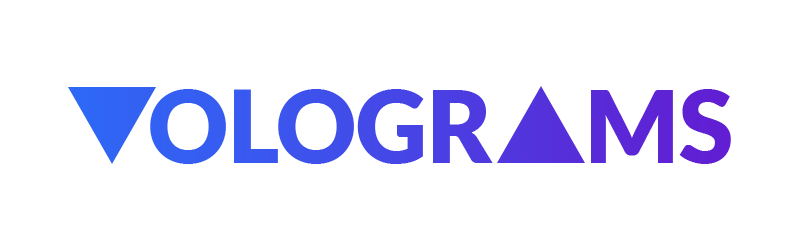

Open topics / issues:
- [ ] Investigate detailed implementation of model including output shapes and activations
- [ ] improve memory usage
  - IDee: First create tensorflow dataset or similar (evtl. on local machine) and then load it directly : No need for reading and creating multiple numpy arrays and therefore I might be able to load more data! 
  - Use TFrecord, and read files batch by batch using prefetch!
- [ ] Fully understand padding in TPU
- [ ] Add details to notebook
- [ ] implement further data augmentations
- [ ] optimize datapipeline using caching and interleaving techniques by profiling performance
- [ ] somehow pprint augumented training data... needs to be done during training since before no pipeline is applied to the dataset... 
- [ ] Load checkpoints or models
- [ ] Create a string from the settings and save them to the log file!
- [ ] check availability of instance norm and upsampling layers on TPU...
- [ ] strided convolution vs downsample vs pooling
- [ ] transpose convolution vs upsampling
- [ ] Relu, vs leaky relu, vs selu, vs elu
- [ ] normalization and initialization of weigths
- [ ] final activation: tanh vs sigmoid, vs other
- [ ] implement asserts to check inputs and settings

Code Cleaning:
- [ ] comply with naming conventions! 
- [ ] for boolean use words like isBool, doBool, useBool, etc...

<a name="0"></a>
# 0 - Initial steps

TODO:
- [ ] write assert function to check correct settings: especially regarding
  - padding of TPU
  - that both test and training set are dividable by 8 for TPU...
  - ....

In [ ]:
#@title # 0.1 Notebook Settings
#@markdown The following PArameters can be adapted to influence the behavior of the notebook.
#@markdown ---

#@markdown ### General:
SAVE_LOCATION = 'local' #@param ["local", "drive"]

#@markdown ---

#@markdown ### Model Architecture:
GENERATOR_DESIGN = 'UNet' #@param ["UNet", "ResNet", "UNet_risidual_bottleneck"]
DISCRIMINATOR_DESIGN = 'PatchGAN' #@param ["PatchGAN", "UNet"]
DATASET_DATATYPE = 'float16' #@param ["float16", "float32"]


#@markdown ---

#@markdown ### Training Parameters:
TRAINING_MODE = 'Training' #@param ["Training", "Hyperparameter Tuning", "Inference"]
EPOCHS =  10#@param {type:"integer"}
#@markdown batchsize of 128 is favorable due to TPU architecture (8cores * 128 batches = 1024samples!)
#@markdown the amount of samples per TPU must be dividable by 8 since there are 8 cores!!!
#@markdown good start for tpu is batch 1 and samples 480 and train_split 0,8
BATCH_SIZE_PER_REPLICA =  1#@param {type:"integer"}
NUM_SAMPLES_TO_LOAD = 480 #@param {type:"slider", min:8, max:2000, step:8}
TRAIN_SPLIT = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}
TRAINING_START = 'Start from scratch' #@param ["Start from scratch", "Load checkpoint", "Load Model"]
CHECKPOINT_MODEL_FILEPATH = "checkpoint/<MODEL>/" #@param {type:"string"}

#@markdown ---

#@markdown ###Validation:
TRAINING_VALIDATION = True #@param {type:"boolean"}
TENSORBOARD_TRAINING = True #@param {type:"boolean"}
TENSORBOARD_MODEL_GRAPH = False #@param {type:"boolean"}
TENSORBOARD_PERFORMANCE_PROFILE = False #@param {type:"boolean"}
EPOCH_TO_PROFILE =  1#@param {type:"integer"} 

#@markdown ---

#@markdown Saving and Loading:
USE_CHECKPOINTS = False #@param {type:"boolean"}
CHECKPOINT_EPOCH_FREQUENCY =  5#@param {type:"integer"}
SAVE_MODELS = False #@param {type:"boolean"}


# Check Inputs:

#check sample count is dividable by 8 for TPU
train_count = NUM_SAMPLES_TO_LOAD * TRAIN_SPLIT
test_count = NUM_SAMPLES_TO_LOAD * (1 - TRAIN_SPLIT)
#assert train_count % 8 == 0 and train_count % 8 == 0, "Number of samples in either train or test set is not dividable by 8"

<a name="0-1"></a>
## 0.2 Mounting the Google Drive

Please run the next code cell and follow these steps to mount your Google Drive so that it can be accessed by this Colab.

Opt 1.
- Execute the code cell below. A web link will appear below the cell where the user can login to drive. **Drawback**: Has to be done with every run time


``` python
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
```


Opt 2.
- Permanently mount drive in the file system of the colab VM

<a name="0-2"></a>
## 0.3 Prepare Real Time Datalogging on Phone

In order to review the output of destinct cells at any time, HyperDash can be used. It is a tool for iOS and Android to monitor cell outputs at real time.

> Link: https://hyperdash.io/ 

In order to track a cell, it needs to be marked with: 

%%monitor_cell “MasterThesis/PatchGAN” 

In [ ]:
#!pip install hyperdash && hyperdash login --github

In [ ]:
#from hyperdash import monitor_cell

<a name="1"></a>
# 1 - Environment

<a name="1-1"></a>
## 1.1 Importing Libraries

In [ ]:
import tensorflow as tf         # Tensorflow framework
import numpy as np              # Tools for working with datastructures
import matplotlib.pyplot as plt # Plot data
import cv2                      # OpenCV for image processing
import tensorflow_addons as tfa # Aditional features for Tensorflow 
import seaborn as sns           # Visualize Data
import pandas as pd             # Organize datastructures
import keras.backend as K       # Aditional Functions for working with Tensors

import os
import io
import random
import time
from zipfile import ZipFile
import json

from tqdm import tqdm
from sklearn.decomposition import PCA

# Print package version of available packages
print("Tensorflow version: \t\t" + tf.__version__)
print("Numpy version: \t\t\t" + np.__version__)
print("Open CV version: \t\t" + cv2.__version__)
print("Tensorflow Ad-Ons version: \t" + tfa.__version__)
print("Seaborn version: \t\t" + sns.__version__)
print("Pandas version: \t\t" + pd.__version__)
!python --version
#!cat /etc/*-release

Tensorflow version: 		2.4.0
Numpy version: 			1.19.5
Open CV version: 		4.1.2
Tensorflow Ad-Ons version: 	0.8.3
Seaborn version: 		0.11.1
Pandas version: 		1.1.5
Python 3.6.9


<a name="1-2"></a>
## 1.2 Distribution Strategy - HW Detection
Depending on the hardware available, different distribution strategies will be applied.

- If the TPU is available, the TPU Strategy is used.
Otherwise:
- If more than one GPU is available, then the Mirrored Strategy is applied
- If one GPU is available or if just the CPU is available, the default strategy is applied.

> Overview Distribution: https://www.tensorflow.org/api_docs/python/tf/distribute

> Tutorial of using td.distrubute on custom training: https://www.tensorflow.org/tutorials/distribute/custom_training

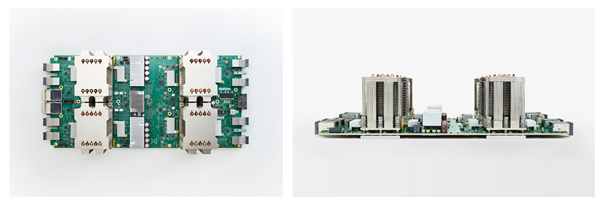

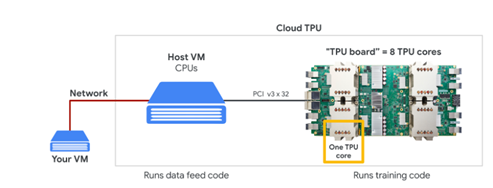

 Param | Value 
 --- | --- 
TPU Cores | 8
HBM | 64GB
FLOPS | 180 teraFLOPS

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


<a name="1-3"></a>
## 1.3 Global Parameters

In [ ]:
#DATA_PATH_SYNTHETIC = os.path.join("/content","drive","My Drive","Master","DatasetVolograms", "Synthetic_Data_Samples")
#DATA_PATH_TARGET = os.path.join("/content","drive","My Drive","Master","DatasetVolograms", "Target_Data_Samples")

# The global batch size is the batch size per replica (1 in this case) times the number of replicas in the distribution strategy (In Colab: 8 for TPU, 1 for GPU and CPU).
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Used for the data piple to feed the data to the network
BUFFER_SIZE = 256

# RGBD Image: Height = Width = 512, Channel: Red, Green, Blue, Depth
IMG_SIZE = (512,512,4)

# Weights initializer for the layers.
KERNEL_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
GAMMA_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

#autotune function for parallelism.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Strategy for reducing the loss whan calculated over several replicas
REDUCTION_STRATEGY = tf.keras.losses.Reduction.NONE

# Name indication model architecture and timestamp. Can be used for saving unic progress. e.g. tensorboard or checkpoints
NAME = "{timestamp}_CycleGAN_G-{gen_design}_D-{disc_design}".format(gen_design = GENERATOR_DESIGN, disc_design = DISCRIMINATOR_DESIGN, timestamp= int(time.time()))

BASE_DRIVE_DIRECTORY = os.path.join("/content","drive","MyDrive","Master","Volograms")
BASE_VM_DIRECTORY = os.path.join("/content")

if SAVE_LOCATION == 'drive':
  BASE_SAVE_DIRECTORY = BASE_DRIVE_DIRECTORY
else:
  BASE_SAVE_DIRECTORY = BASE_VM_DIRECTORY #local storage on VM


#Directory for checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

<a name="2"></a>
# 2 - Utilities and Helper Functions

>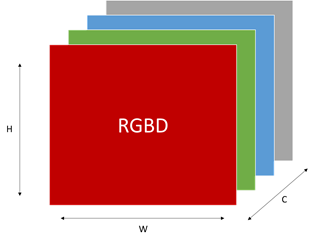


Param | Value
--- | ---
Height | 512
Width | 512
Channel | 4

In [ ]:
def Plot_RGBD_Sample(rgbd, normalize = False, title = "RGBD Plot"):
  
  # local copy is requiered since rgbd is an array and therefore passed by refference. that means rgbd =/ 255, would change the array even outside the scope of thid function
  if normalize: # Only applicable ffor float 32
    rgbd_local = rgbd/255
  else:
    rgbd_local = rgbd.astype(np.float32) # Matplotlib can not plot float16

  fig = plt.figure()
  fig = plt.figure(figsize=[12,6])
  fig.suptitle(title, fontsize=20)
  
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(rgbd_local[:,:,0:3])
  ax.set_title('RGB')
  plt.colorbar(orientation='horizontal')
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(rgbd_local[:,:,3])
  ax.set_title('Depth')
  plt.colorbar()

  plt.show()

def Plot_RGBD_Seperatly(rgbd, normalize = False, title = "RGBD Plot"):
  if normalize:
    rgbd_local = rgbd/255
  else:
    rgbd_local = rgbd.astype(np.float32) # Matplotlib can not plot float16

  fig = plt.figure()
  fig = plt.figure(figsize=[24,6])
  fig.suptitle(title, fontsize=20)

  ax = fig.add_subplot(1, 5, 1)
  imgplot = plt.imshow(rgbd_local[:,:,0:3])
  ax.set_title('RGB')

  ar = fig.add_subplot(1, 5, 2)
  imgplot = plt.imshow(rgbd_local[:,:,0], cmap='Reds')
  ar.set_title('Red')

  ag = fig.add_subplot(1, 5, 3)
  imgplot = plt.imshow(rgbd_local[:,:,1], cmap='Greens')
  ag.set_title('Green')

  ab = fig.add_subplot(1, 5, 4)
  imgplot = plt.imshow(rgbd_local[:,:,2], cmap='Blues')
  ab.set_title('Blue')

  ad = fig.add_subplot(1, 5, 5)
  imgplot = plt.imshow(rgbd_local[:,:,3])
  ad.set_title('Depth')

  plt.show()

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def Plot_generator_prediction(input, prediction, title, writeToTensorboard = False, epoch = None):
    #input_local = input.astype(np.float32) # input from dataset might be float16

    fig = plt.figure(figsize=[12,4])
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(1, 4, 1)
    imgplot = plt.imshow(input[:,:,0:3])
    ax.set_title('Input RGB')
    ax.axis("off")

    ax = fig.add_subplot(1, 4, 2)
    imgplot = plt.imshow(input[:,:,3])
    ax.set_title('Input Depth')
    ax.axis("off")

    ax = fig.add_subplot(1, 4, 3)
    imgplot = plt.imshow(prediction[:,:,0:3])
    ax.set_title('Output RGB')
    ax.axis("off")

    ax = fig.add_subplot(1, 4, 4)
    imgplot = plt.imshow(prediction[:,:,3])
    ax.set_title('Output Depth')
    ax.axis("off")

    if writeToTensorboard:
      with tf.device('/job:localhost'): 
        with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME,"val")).as_default():
          tf.summary.image("Prediction", plot_to_image(fig), step= epoch)
    else:
      plt.show()

    
def Plot_discriminator_prediction(input, prediction, title):
  #input_local = input.astype(np.float32) # input from dataset might be float16
  
  fig = plt.figure(figsize=[12,6])
  fig.suptitle(title, fontsize=20)
  ax = fig.add_subplot(1, 3, 1)
  imgplot = plt.imshow(input[:,:,0:3])
  ax.set_title('Input RGB')
  ax.axis("off")

  ax = fig.add_subplot(1, 3, 2)
  imgplot = plt.imshow(input[:,:,3])
  ax.set_title('Input Depth')
  ax.axis("off")

  ax = fig.add_subplot(1, 3, 3)
  imgplot = plt.imshow(prediction[0,...,-1], cmap='RdBu_r')
  ax.set_title('Prediction')
  ax.axis("off")
  plt.colorbar()

  plt.show()



<a name="3"></a>
# 3 - Preparing the Data

TODO: 
- [ ] kapitel passen nicht mehr nachdem etwas bearbeitet...

<a name="3-1"></a>
## 3.1 Load Data

When run the first time, data is downloaded from the drive and stored in the colab session. after that it runs faster.

TODO:
- [x] define number of samples in global parameters

Copying zip-file from Drive to VM as whole and then unzip is way faster then loading image by image!

> Unzipping: https://linuxize.com/post/how-to-unzip-files-in-linux/

> JSON Tips: https://www.programiz.com/python-programming/json

The content of the json file has to following format:


```json
{
  "synthetic_data": [
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.exr",
       "color_path": "RENDER/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.jpg"
    },
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.jpg"
    }
    ...
  ],
  "real_data": [
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.jpg"
    },
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.jpg"
    }
    ...
  ]
}
```



TODO:
- [ ] rethink depth normalization. Better distribute between 0 and 1 and not only divide by max value ( here 255)



---

I learned the hardway that numpy is super memory expensive, since with every operation a copy of the object is created. in addition, the standard format of numbers (float or int) is using 64 bit, which also rewquires a lot of memory. Below a code snippet which worked good, with the problem, that the returned values were lists not np.ndarrays anymore...

Option1 - Initial Code:



```python
for i, sample in enumerate(data_dict):
        image = cv2.imread(os.path.join(BASE_DATA_PATH, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
        depth = cv2.imread(os.path.join(BASE_DATA_PATH, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        # normalize images to have values between 0..1
        images.append(image / 255) # 8bit int -> int8
        depths.append(depth / 255) # float32 -> 1bit sign, 8bit for exponent, 23bit for fraction
        print(".", end = "")
        if (i+1) % 100 == 0:
          print ("")

        if (i+1) == readCount:
          break
```

Option2 - A bit better code:


```python
for i, sample in enumerate(data_dict):
        image = cv2.imread(os.path.join(BASE_DATA_PATH, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
        depth = cv2.imread(os.path.join(BASE_DATA_PATH, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32

        image = image / 255
        depth = depth / 255
        combined.append(np.concatenate((image , np.expand_dims(depth, axis = 2)), axis = 2).astype(np.float32)) #saved as float32, since after division with 255, datatype is float64

        print(".", end = "")
        if (i+1) % 100 == 0:
          print ("")

        if (i+1) == readCount:
          break
```





In [ ]:
# Folder must be located at "/content/drive/My Drive/Master/DatasetVolograms"+directoryName+".zip"
def Load_and_Combine_Training_Samples(directoryName, NumberOfSamplesToRead = None):
  '''
  Function that reads the training data. Each training sample consists of 
  1 RGB image with the shape (512,512,3) and one depth image with the shape
  (512,512,1). The files are read and combined into an array of training sample
  of (num_samples, 512,512,4). The files are provided in zip file, containing 
  synthetic_samples, real_samples and a path.json file.

  Inputs:
    1. directoryName: String,  base directory of the location of the json file
    2. NumberOfSamplesToRead:  int or None. If int, the number of samples provided
                              are returned. If None, all available samples are 
                              provided.

  Outputs:
    1. rgbd_synthetic:  numpy array of shape (num_samples, 512, 512, 4) 
                        containing the synthetic samples
    2. rgbd_real:       numpy array of shape (num_samples, 512, 512, 4) 
                        containing the real samples

  '''

  #Defeine paths
  zipFile = os.path.join(BASE_DRIVE_DIRECTORY, "Datasets", directoryName+".zip")
  unzipDirectory = os.path.join(BASE_VM_DIRECTORY, directoryName)
  jsonConfigFile = os.path.join(unzipDirectory, "training_paths.json")

  #Unzip data
  if os.path.isdir(unzipDirectory):
    print("Data already unzipped.")
  else:
    with ZipFile(zipFile, 'r') as zipObj:
      # Extract all the contents of zip file in different directory
      print('Start Unzipping file {} to {}'.format(zipFile,unzipDirectory)) 
      zipObj.extractall(unzipDirectory)
      print('Finnished unzipping')

  # Read json config file
  print("Read config file...")
  with open(jsonConfigFile) as f:
    data = json.load(f)

  def Read_and_Combine(data_dict, info_str = ""):
    numberOfSamples = len(data_dict)

    #randomize Filenames!
    random.shuffle(data_dict)

    if NumberOfSamplesToRead:
      # incase more samples are requested as there are available
      readCount = min(numberOfSamples, NumberOfSamplesToRead)
    else:
      readCount = numberOfSamples  

    #empty array container
    combined = []

    print("------------------------------------------------------------------------------------------------------------------------------")
    print("Identified {} samples of {}".format(numberOfSamples, info_str))
    if readCount > 0:
      print("Start reading {} of {} samples of {} ...".format(readCount,numberOfSamples, info_str))
      for i, sample in enumerate(data_dict):
        image = cv2.imread(os.path.join(unzipDirectory, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
        depth = cv2.imread(os.path.join(unzipDirectory, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32
 
        image = image / 255
        depth = depth / 255
        combined.append(np.concatenate((image , np.expand_dims(depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE))) #saved as float32, since after division with 255, datatype is float64
 
        print(".", end = "")
        if (i+1) % 100 == 0:
          print ("")
 
        if (i+1) == readCount:
          break

      print("\nShape of combined images and depths: {}, where (Sample, Height, Width, Channel)".format(np.shape(combined)))
      
    else:
      print("No data will be read.")

    return np.array(combined, dtype = np.dtype(DATASET_DATATYPE))

  rgbd_synthetic = Read_and_Combine(data['synthetic_data'], "synthetic data")
  rgbd_real = Read_and_Combine(data['real_data'], "real data")

  return rgbd_synthetic, rgbd_real



<a name="3-2"></a>
## 3.2 Create Dataset





HINT: Ich sollte drauf achten, dass der Split ein vielfaches von 8 oder 128 ist, da die TPU damit optimal funktioniert! 

As datatype, bfloat16 is used, a special type created for tensor computations: https://codelabs.developers.google.com/codelabs/keras-flowers-tpu#2
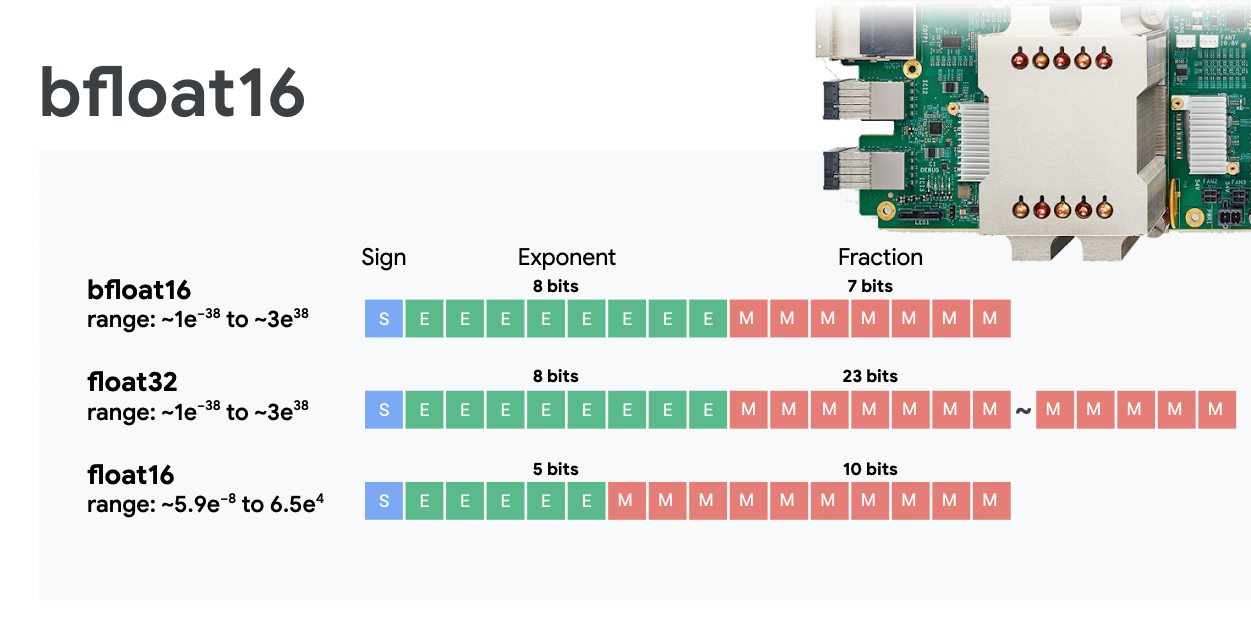

In [ ]:
def Create_tensorflow_dataset(data, trainSplit = 0.8):
  '''
  Creates a TensorFlow dataset from a numpy tensor and optionally diveds the
  dataset into a train and test set..

  Inputs:  
    1. data:        Numpy array, samples of shape (num_sumples, 512, 512, 4)
    2. trainSplit:  float, value between 0...1. A training and a testset will
                    be returned according the ratio

  Outputs:
    [train, test], array tensorflow dataset:  contains one tensorflow dataset 
                                              split in train and test according
                                              the param trainSplit
  '''

  assert trainSplit <= 1.0 and trainSplit >=0 , "trainSplit needs to be a float between 0...1"

  numberOfSamples = data.shape[0]  
  train_size = int(trainSplit * numberOfSamples)
  #train = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data[:train_size,...],dtype=tf.bfloat16))
  #test = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data[train_size:,...],dtype=tf.bfloat16))
  train = tf.data.Dataset.from_tensor_slices(data[:train_size,...])
  test = tf.data.Dataset.from_tensor_slices(data[train_size:,...])
  print("\nDataset created. Total samples: {}, training split: {}, training samples: {}, test samples: {}".format(numberOfSamples, trainSplit, train_size, numberOfSamples-train_size))
  return [train, test]
    

<a name="3-2-1"></a>
### 3.2.1 Define Preprocessing

To check:


1.   Werden bei dataaugmentation wirklich neue samples erzeugt, oder werden einfach nur die batches jedes mal neu geshuffelt zund somit ist in jeder epoche die Daten anders?

2.   Checken wie ich die depth daten am besten normalisiere... in den synthetischen ist der max value 5, der background. Die daten von der target domain kenne ich noch nicht... 


Tensorflow Image API: https://www.tensorflow.org/api_docs/python/tf/image

Guide for Data Augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation

API for using Keras Layers for augmentation!: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

Further augmentation ideas:
- cut-mix
- additve noise 
- sheer
- lightning / brightness
- pre-augmentation vs. augmentation in pipeline ( less discspace and RAM required to store all data!!!)
---

Ggf. muss ich das image splitten in RGB und D bevor ich es preprozesse, da viele sachen nur für RGB...



Shift Image augmentation

Zero padding is working to shift the image, since all pixels except of the person in the center are zero

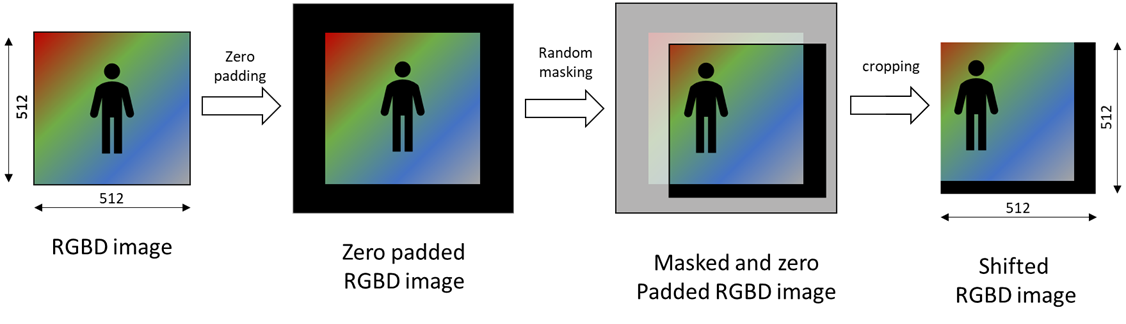

In [ ]:
def Shift_image(img):
  img = tf.image.pad_to_bounding_box(image = img, offset_height = 0, offset_width = 0, target_height = (512 + 48), target_width = (512 + 200))
  img = tf.image.random_crop(value = img, size = IMG_SIZE)
  return img

def Normalize_Image(synthetic_rgbd, target_rgbd):
  # TODO: Implement!
  #img = tf.cast(img, dtype=tf.float32)
  #img[:,:,:3] /= 255  #first 3 Channel are RGB values, with 8bit, therfore normalize to 0...1
  #img[:,:,3:] /= 5
  return synthetic_rgbd, target_rgbd

def Augmentate_Data(synthetic_rgbd, target_rgbd):
  synthetic_rgbd = tf.image.random_flip_left_right(synthetic_rgbd)
  synthetic_rgbd = Shift_image(synthetic_rgbd)

  target_rgbd = tf.image.random_flip_left_right(target_rgbd)
  target_rgbd = Shift_image(target_rgbd)

  return synthetic_rgbd, target_rgbd

@tf.function
def Preprocess_Train_Data(synthetic_rgbd, target_rgbd):
  synthetic_rgbd, target_rgbd = Augmentate_Data(synthetic_rgbd, target_rgbd)
  synthetic_rgbd, target_rgbd = Normalize_Image(synthetic_rgbd, target_rgbd)
  return synthetic_rgbd, target_rgbd

@tf.function
def Preprocess_Test_Data(synthetic_rgbd, target_rgbd):
  synthetic_rgbd, target_rgbd = Normalize_Image(synthetic_rgbd, target_rgbd)
  return synthetic_rgbd, target_rgbd

<a name="3-2-2"></a>
### 3.2.2 Define Dataset Pipeline

Information to applied functions here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

IMPORTANT: Call Can only be run once in Colab.... after that, the dataset needs to be created newly. 

TODO:
- [ ] Check benefits of TF Records! https://www.tensorflow.org/tutorials/load_data/tfrecord
- [ ] Check interleaving 
- [ ] chaching tequniques
- [ ] update discription of get_Datasets
- [ ] Autotune splited dataset that it complies with batch size! 

When training on the TPU, synchronous data paralism is applied. In data parallel training, the same model is distributed among multiple devices. Each device is trained on a subset of the training batch. The loss of all devices is reduced by for example adding them or averaging them, depending on the loss function used. Finally, the gradients are calculated, and the model is updated on all devices. In that scenario, a single thread of the client can drive the training loop, while bulk of the model computation is distributed among several devices.

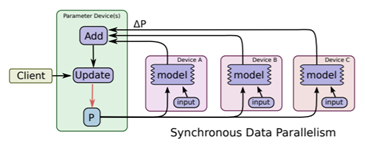

Hint: IT seems that shuffling in the test set is not required!: https://towardsdatascience.com/writing-efficient-input-pipelines-using-tensorflows-data-api-2dfc3b3ce077

Optimizing Input pipeline performance: https://www.tensorflow.org/guide/data_performance

In [ ]:
def get_Datasets(rgbd_synthetic, rgbd_target):
  ''' 
    Input:
      rgbd_synthetic:   dataset of rgbd images from the synthetic domain. Shape: (num_samples, height, width, channel)
      rgbd_target:      dataset of rgbd images from the target domain. Shape: (num_samples, height, width, channel)
    
    Output:
      train_distributed: Distributed and ziped dataset of training images ((batch, height, width, channel),(batch, height, width, channel)) where ((train_synthetic),(train_target))
      test_distributed: Distributed and ziped dataset of test images ((batch, height, width, channel),(batch, height, width, channel)) where ((test_synthetic),(test_target))
  '''
  #Create Tensorflow Datasets for the synthetic and the target data and split them into training and test sets. 
  train_synthetic, test_synthetic = Create_tensorflow_dataset(rgbd_synthetic, trainSplit = TRAIN_SPLIT)
  train_target, test_target = Create_tensorflow_dataset(rgbd_target, trainSplit = TRAIN_SPLIT)

  #create a single train set and a single test set from the synthetic and the target data. IMPORTANT: Shapes need to match
  train = tf.data.Dataset.zip((train_synthetic, train_target))
  test = tf.data.Dataset.zip((test_synthetic, test_target))

  return train, test

def get_distributed_Datasets(train, test):
  #create distributed datasets to distribute among TPUs

  # Define pipelines
  train = (
    train.map(Preprocess_Train_Data, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=False)
    .prefetch(AUTOTUNE)
  )

  test = (
    test.map(Preprocess_Test_Data, num_parallel_calls=AUTOTUNE)
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=False)
    .prefetch(AUTOTUNE)
  )

  train_distributed = strategy.experimental_distribute_dataset(train)
  test_distributed = strategy.experimental_distribute_dataset(test)

  return train_distributed, test_distributed

In [ ]:
#!rm -rf training_synthetic_995_real_XXX

In [ ]:
#Load data
directoryName = 'training_synthetic_995_real_XXX' #@param ["training_paths_only_synthetic_995", "training_synthetic_995_real_XXX"]
rgbd_synthetic, rgbd_target = Load_and_Combine_Training_Samples(directoryName, NUM_SAMPLES_TO_LOAD)

#create Dataset
trainDataset, testDataset = get_Datasets(rgbd_synthetic, rgbd_target)

# free up RAM
del rgbd_synthetic, rgbd_target

Start Unzipping file /content/drive/MyDrive/Master/Volograms/Datasets/training_synthetic_995_real_XXX.zip to /content/training_synthetic_995_real_XXX
Finnished unzipping
Read config file...
------------------------------------------------------------------------------------------------------------------------------
Identified 995 samples of synthetic data
Start reading 480 of 995 samples of synthetic data ...
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................
Shape of combined images and depths: (480, 512, 512, 4), where (Sample, Height, Width, Channel)
------

<a name="3-3"></a>
## 3.3 Analyze Data

The analysis of the data is performed on the test data. The training data is augmentated, and therefor not representative anymore! the testdata is only normalized.

HINT: Matplotlib does not support float 16 ... 

Ideas:
- Image gradients (detect smoothnes of images and edges)
- 

<a name="3-3-1"></a>
### 3.3.1 Plot Test Samples

In [ ]:
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:

  dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset

  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

  #Inspect Datasamples
  Plot_RGBD_Sample(rgbd_synthetic[0,...], title = "Synthetic Domain RGBD Example")
  Plot_RGBD_Sample(rgbd_target[0,...],  title = "Target Domain RGBD Example")
  Plot_RGBD_Seperatly(rgbd_synthetic[0,...],  title = "Synthetic Domain RGBD Example")
  Plot_RGBD_Seperatly(rgbd_target[0,...], title = "Target Domain RGBD Example")

  del dataset, rgbd_synthetic, rgbd_target

<a name="3-3-2"></a>
### 3.3.2 Principal Component Analysis

WICHTIG:
- first combine data and then perform PCA



---



Guides:
> Principal Component Analysis in 3 Simple Steps: https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html


---


TODO:
- [ ] write PCA method that is called later

In [ ]:
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  # Test Code for PCA - Fit synthetic and trget domain seperately and then create a single data set
  
  dataset = list(testDataset.take(-1).as_numpy_iterator()) # get all samples of the dataset
  
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)
  del dataset
  
  pca = PCA(5)
  shape_synthetic = rgbd_synthetic.shape
  num_samples_synthetic = shape_synthetic[0]
  flatten_length_synthetic = shape_synthetic[1] * shape_synthetic[2] * shape_synthetic[3]

  shape_target = rgbd_target.shape
  num_samples_target = shape_target[0]
  flatten_length_target = shape_target[1] * shape_target[2] * shape_target[3]

  print("rgbd_synthetic.shape: {}".format(shape_synthetic))
  print("rgbd_target.shape: {}".format(shape_target))
  temp1 = np.reshape(rgbd_synthetic,(num_samples_synthetic,flatten_length_synthetic))
  temp2 = np.reshape(rgbd_target,(num_samples_target,flatten_length_target))
  del rgbd_synthetic, rgbd_target

  print("temp1.shape: {}".format(temp1.shape))
  print("temp2.shape: {}".format(temp2.shape))
  projected1 = pca.fit_transform(temp1)
  projected2 = pca.fit_transform(temp2)
  del temp1, temp2
  print("projected1.shape: {}".format(projected1.shape))
  print("projected2.shape: {}".format(projected2.shape))

  df1 = pd.DataFrame(projected1)
  df1['domain'] = 'synthetic'
  df2 = pd.DataFrame(projected2)
  df2['domain'] = 'target'
  df12 = df1.append(df2)
  del projected1, projected2, df1, df2

  g = sns.pairplot(data=df12, hue='domain')
  g.map_diag(sns.kdeplot)
  g.add_legend()

  del df12, g

In [ ]:
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  # Test Code for PCA - combine synthetic and target domain, perform pca and then create a single data set
  
  dataset = list(testDataset.take(-1).as_numpy_iterator()) # get all samples of the dataset
  
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)
  del dataset
  
  pca = PCA(5)
  shape_synthetic = rgbd_synthetic.shape
  num_samples_synthetic = shape_synthetic[0]
  flatten_length_synthetic = shape_synthetic[1] * shape_synthetic[2] * shape_synthetic[3]

  shape_target = rgbd_target.shape
  num_samples_target = shape_target[0]
  flatten_length_target = shape_target[1] * shape_target[2] * shape_target[3]

  print("rgbd_synthetic.shape: {}".format(shape_synthetic))
  print("rgbd_target.shape: {}".format(shape_target))

  # reshape inputs
  temp1 = np.reshape(rgbd_synthetic,(num_samples_synthetic,flatten_length_synthetic))
  temp2 = np.reshape(rgbd_target,(num_samples_target,flatten_length_target))
  
  del rgbd_synthetic, rgbd_target

  # concatenet inputs
  temp = np.concatenate((temp1, temp2), axis = 0)  
  print(temp1.dtype)
  print(temp2.dtype)
  print(temp.dtype)
  # Free RAM memory
  del temp1, temp2
  print("rgbd_concatenated.shape: {}".format(temp.shape))

  # apply pca transformation
  projected = pca.fit_transform(temp)
  del temp
  print("projected.shape: {}".format(projected.shape))

  # create pandas dataframe
  df1 = pd.DataFrame(projected[:num_samples_synthetic])
  df1['domain'] = 'synthetic'
  df2 = pd.DataFrame(projected[num_samples_synthetic:])
  df2['domain'] = 'target'
  df12 = df1.append(df2)
  del projected, df1, df2

  # plot data
  g = sns.pairplot(data=df12, hue='domain')
  g.map_diag(sns.kdeplot)
  g.add_legend()

  # Free RAM memory (When run in method, garbage collection should take cake when scope left)
  del df12, g

<a name="4"></a>
# 4 - Defining the Model

Usefull Links:


*   Layer API: https://www.tensorflow.org/api_docs/python/tf/keras/layers
*   Model API: https://www.tensorflow.org/api_docs/python/tf/keras/Model
*   Tensorflow AdOns API: https://www.tensorflow.org/addons/api_docs/python/tfa 
*   Tensor Flow Dataset API (not tfds!): https://www.tensorflow.org/api_docs/python/tf/data/Dataset


---




Hint from TensorFlow Documentation (https://www.tensorflow.org/guide/keras/custom_layers_and_models):

"*In general, you will use the Layer class to define inner computation blocks, and will use the Model class to define the outer model -- the object you will train.*"

Ich werde trotzdem ein Model nehmen, einfach wegen summary and plot!







<a name="4-1"></a>
## 4.1 Custom Layer
Keep in Mind: There are <b>no activations possible in custom layers</b> if not manually implemented!

<a name="4-2"></a>
## 4.2 Sub-Model Blocks

<a name="4-2-1"></a>
### 4.2.1 Down-Sample Model Block

<b>TODO:</b> 


1.   Vergleich verschiedener Downsample Blöcke.
  1.   Conv2D
  2.   Pooling
  3.   Downsample Block
  3.   Mehrere Convolution, dann downsampling






In [ ]:
print(tf.keras.activations.get("relu"))
print(tf.keras.activations.get("selu"))
print(tf.keras.activations.get("elu"))
print(tf.keras.activations.get(tf.nn.leaky_relu))
print(tf.keras.activations.get(tf.nn.selu))
print(tf.keras.activations.get(tf.nn.relu))
print(tf.keras.activations.get(tf.nn.elu))

<function relu at 0x7fd48ccef378>
<function selu at 0x7fd48cd4dea0>
<function elu at 0x7fd48cd4dd90>
<function leaky_relu at 0x7fd49407c7b8>
<function selu at 0x7fd4966f2ea0>
<function relu at 0x7fd4966f2620>
<function elu at 0x7fd496775e18>


In [ ]:
def DownSampleBlock(input, numOfChannels, kernel_size = (3,3), kernel_initializer = KERNEL_INIT, gamma_initializer = GAMMA_INIT, activation = 'relu'):
  x = tf.keras.layers.Conv2D(numOfChannels, kernel_size, strides=(2,2), kernel_initializer = kernel_initializer, padding='same', use_bias = False)(input)
  x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
  x = tf.keras.activations.get(activation)(x)
  return x

<a name="4-2-2"></a>
### 4.2.2 Up-Sample Model Block

It seems that using Upsampling2D is favorable over Conv2DTranspose (see book Generative Deep Learning Teaching Machines to Paint, Write, Compose and Play)

In [ ]:
def UpSampleBlock(input, numOfChannels, name = None, useUpsampleLayer = True , kernel_size = (3,3), kernel_initializer = KERNEL_INIT, gamma_initializer = GAMMA_INIT, activation = 'relu'):
  if useUpsampleLayer:
    x = tf.keras.layers.UpSampling2D()(input)
    x = tf.keras.layers.Conv2D(numOfChannels, kernel_size, kernel_initializer = kernel_initializer, padding='same', use_bias = False)(x)
  else:
    x = tf.keras.layers.Conv2DTranspose(numOfChannels,kernel_size,strides=(2,2),kernel_initializer = kernel_initializer,padding='same',use_bias = False)(input)
  x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
  x = tf.keras.activations.get(activation)(x)
  return x

#Testcode
#inputs = tf.keras.layers.Input(shape = (128,128,256))

# create the model
#model = tf.keras.Model(inputs=inputs, outputs=UpSampleBlock(inputs, numOfChannels = 128))

#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=False)
#del model

<a name="4-2-3"></a>
### 4.2.3 Residual Identity Model Block

Der unten gezeigte Residualblock unterscheidet sich noch von dem CycleGAN Beispiel...

Idea: Deep Residual Learning for Image Recognition http://arxiv.org/abs/1512.03385 

Fazit: 
- Deep version has much less numbers of parameters while having similar performance!!!


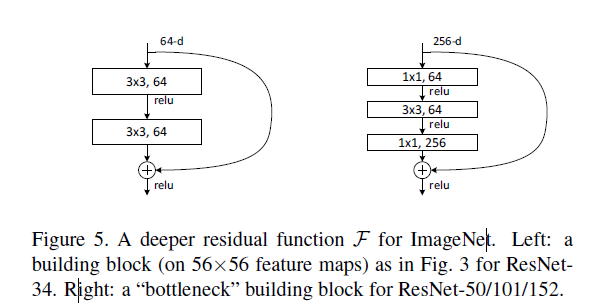

TODO:
- Check whether to use batchnorm or instance norm... upsampleblock and downsampleblock use instancenorm...

In [ ]:
def ResidualIdentityBlock(input, activation = 'relu', useBottleneckIdentity = False):
  numFilters = K.int_shape(input)[-1]
  
  if useBottleneckIdentity:
    x = tf.keras.layers.Conv2D(int(numFilters/4), kernel_size = (1,1), strides = (1,1), padding = 'same')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.get(activation)(x)

    x = tf.keras.layers.Conv2D(int(numFilters/4), kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.get(activation)(x)

    x = tf.keras.layers.Conv2D(numFilters, kernel_size = (1,1), strides = (1,1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

  else:
    x = tf.keras.layers.Conv2D(numFilters, kernel_size = (3,3), strides = (1,1), padding = 'same')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.get(activation)(x)

    x = tf.keras.layers.Conv2D(numFilters, kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
  x = tf.keras.layers.Add()([x, input])
  x = tf.keras.activations.get(activation)(x)

  return x 



#Testcode
#inputs = tf.keras.layers.Input(shape = (128,128,256))

# create the model
#model = tf.keras.Model(inputs=inputs, outputs=ResidualIdentityBlock(inputs, useBottleneckIdentity = False))

#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=False)
#del model

<a name="4-4"></a>
## 4.4 Model Blocks

TODO: 
- [ ] Check VGG-16 and transferlearning for generator using perceptual loss: https://arxiv.org/abs/2012.04781 

<a name="4-4-1"></a>
### 4.4.1 U-Net

Idea: http://arxiv.org/abs/1505.04597

TODO: 
- check decoder stride... 3 seems strange, would expect 2

Standard U-Net

My DEviations:
- Instance norm
- padding = same, no cropping
- leaky relu in down path, relu in up-path
- bigger images

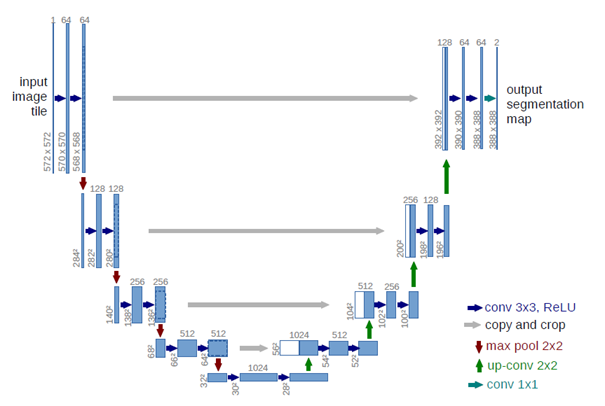

U-Net with risidual bottleneck

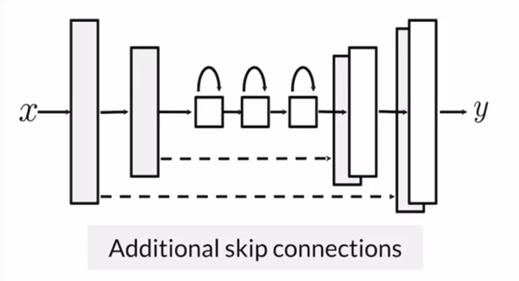

Helper:

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = KERNEL_INIT, padding = 'same')(x)
    #x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x

Encoder Part:

In [ ]:
def encoder_block(inputs, n_filters, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs, number_of_layers, n_filters):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''

  #f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  #f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  #f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  #f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  #return p4, (f1, f2, f3, f4)

  p = inputs
  f = []

  for i in range(number_of_layers):
    number_of_filters = n_filters * 2**i #i=0 -> 64, i=1 -> 128, i=2 -> 256, ...
    temp, p = encoder_block(p, n_filters=number_of_filters, pool_size=(2,2), dropout=0.3)
    f.append(temp)
  
  return p, f

Bottleneck Part:

In [ ]:
def bottleneck(inputs, useResidualBottleNeck, numOfResidualLayers, useBottleneckIdentity):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  numFilters = K.int_shape(inputs)[-1]

  x = inputs

  if useResidualBottleNeck:
    for i in range(numOfResidualLayers):
      x = ResidualIdentityBlock(input = x, useBottleneckIdentity = useBottleneckIdentity)  

  else:
    x = conv2d_block(x, n_filters=numFilters)

  return x

Decoder Part:

In [ ]:
def decoder_block(inputs, conv_output, useUpsampleLayer, n_filters, kernel_size=3, strides=2, dropout=0.3, kernel_initializer = KERNEL_INIT):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''

  if useUpsampleLayer:
    u = tf.keras.layers.UpSampling2D()(inputs)
    u = tf.keras.layers.Conv2D(n_filters, kernel_size, kernel_initializer = kernel_initializer, padding='same', use_bias = False)(u)
  else:
    u = tf.keras.layers.Conv2DTranspose(n_filters,kernel_size, strides=strides, kernel_initializer = kernel_initializer,padding='same',use_bias = False)(inputs)

  #u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  
  c = tf.keras.layers.concatenate([u, conv_output])
  c = conv2d_block(c, n_filters, kernel_size=3)
  c = tf.keras.layers.Dropout(dropout)(c)

  return c


def decoder(inputs, convs, useUpsampleLayer, n_filters, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  number_of_layers = len(convs)
  
  #f1, f2, f3, f4 = convs

  #c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  #c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  #c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  #c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  #outputs = tf.keras.layers.Conv2D(output_channels, (1, 1))(c9)

  #return outputs

  c = inputs

  for i in reversed(range(number_of_layers)):
    number_of_filters = n_filters * 2**i  #i=0 -> 64, i=1 -> 128, i=2 -> 256, ... Hint: Reversed! 
    c = decoder_block(c, convs[i], useUpsampleLayer, n_filters = number_of_filters, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1))(c)

  return outputs

Final U-Net Model

In [ ]:
def UNet(inputShape = IMG_SIZE, number_of_layers = 4, useUpsampleLayer = False, n_filters = 64, useResidualBottleNeck = True, numOfResidualLayers = 3, useBottleneckIdentity = False, name = None):
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape = inputShape)

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs, number_of_layers, n_filters)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output, useResidualBottleNeck, numOfResidualLayers, useBottleneckIdentity)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, useUpsampleLayer, n_filters, output_channels=inputShape[-1])
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name = name)

  return model

#Testcode
model = UNet()
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)
del model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

<a name="4-4-2"></a>
### 4.4.2 ResNet

Idea taken from: https://arxiv.org/abs/1512.03385


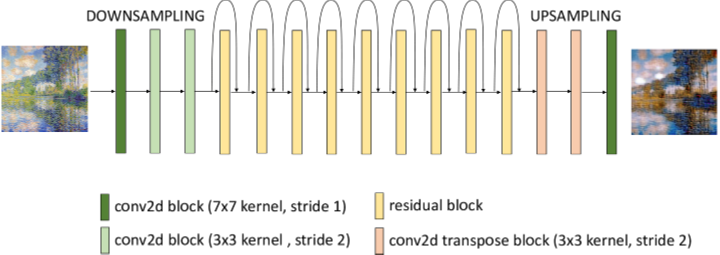

TODO: Implement ResNET Version with downsampling ResNET Blocks and Upsampling ResNET Blocks

Idea: Deep Residual Learning for Image Recognition http://arxiv.org/abs/1512.03385

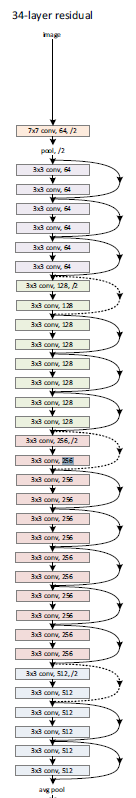

In [ ]:
def ResNet(inputShape = IMG_SIZE, name = None, n_filters=64,  num_up_down_blocks = 4, num_res_blocks = 16, useUpsampleLayer = True):
  inputImageChannels = inputShape[-1]

  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  x = input_tensor
  
  #Downsampling Blocks
  for i in range(num_up_down_blocks):
    number_of_filters = n_filters * 2**i #i=0 -> 64, i=1 -> 128, i=2 -> 256, ...
    x = DownSampleBlock(input = x, numOfChannels = number_of_filters)
    
  #Residual Blocks
  for i in range(num_res_blocks):
    x = ResidualIdentityBlock(input = x, useBottleneckIdentity = True)

  #Upsampling Blocks
  for i in reversed(range(num_up_down_blocks)):
    number_of_filters = n_filters * 2**i  #i=0 -> 64, i=1 -> 128, i=2 -> 256, ... Hint: Reversed!
    x = UpSampleBlock(input= x, numOfChannels = number_of_filters, useUpsampleLayer = useUpsampleLayer)

  x = tf.keras.layers.Conv2D(inputImageChannels, (1, 1))(x)

  return tf.keras.Model(inputs=input_tensor, outputs=x, name = name)

# Test Code
#model = ResNet(inputShape = IMG_SIZE, name = "ResNet")
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)
#del model

<a name="4-4-3"></a>
### 4.4.3 PatchGAN Discriminator

The PatchGAN has been used in the Pix2Pix model: https://www.tensorflow.org/tutorials/generative/pix2pix

Instead of having only a single output classification of the discriminator, the PatchGAN, provides a prediction for several patches of the image

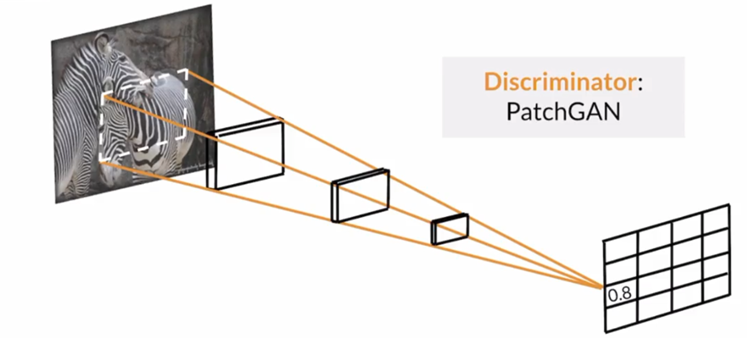

In [ ]:
#%%monitor_cell “MasterThesis/PatchGAN”
def PatchGAN(inputShape = IMG_SIZE, name = None, num_down_blocks = 4, kernel_initializer = KERNEL_INIT):
  inputImageChannels = inputShape[-1]

  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  x = input_tensor

  #Downsampling Blocks
  for i in range(num_down_blocks):
    x = DownSampleBlock(input = x, numOfChannels = inputImageChannels * (2**i))

  x = tf.keras.layers.ZeroPadding2D()(x)
  x = tf.keras.layers.Conv2D(inputImageChannels * (2**(num_down_blocks + 1)), 4, strides=1, kernel_initializer = kernel_initializer, use_bias=False)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.ZeroPadding2D()(x)
  x = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer = kernel_initializer)(x)

  return tf.keras.Model(inputs=input_tensor, outputs=x, name = name)

#model = PatchGAN(name = "PatchGAN")
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

# Test forward Propagation
#dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset
# swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
#rgbd_synthetic, _ = np.einsum('dshwc->sdhwc', dataset)

#img = rgbd_synthetic[0,...]
#Plot_RGBD_Sample(img)
#output = model(img[tf.newaxis,...], training = False)
#plt.imshow(output[0,...,-1], cmap='RdBu_r')
#plt.colorbar()

#del model#, dataset, img, output, rgbd_synthetic, _

<a name="4-4-4"></a>
### 4.4.4 U-Net Discriminator
> Idea taken from: https://openaccess.thecvf.com/content_CVPR_2020/papers/Schonfeld_A_U-Net_Based_Discriminator_for_Generative_Adversarial_Networks_CVPR_2020_paper.pdf

> Git: https://github.com/boschresearch/unetgan 

> Clarifications of the paper: https://github.com/boschresearch/unetgan/blob/master/how_to_unetgan.pdf

The basic idea is to use a U-Net to generate a pixel-wise prediction (decoder output) and a global prediction (encoder output) in the discriminator to strengthen the discriminator. In that way, the generator can benefit from a better feedback of the discriminator

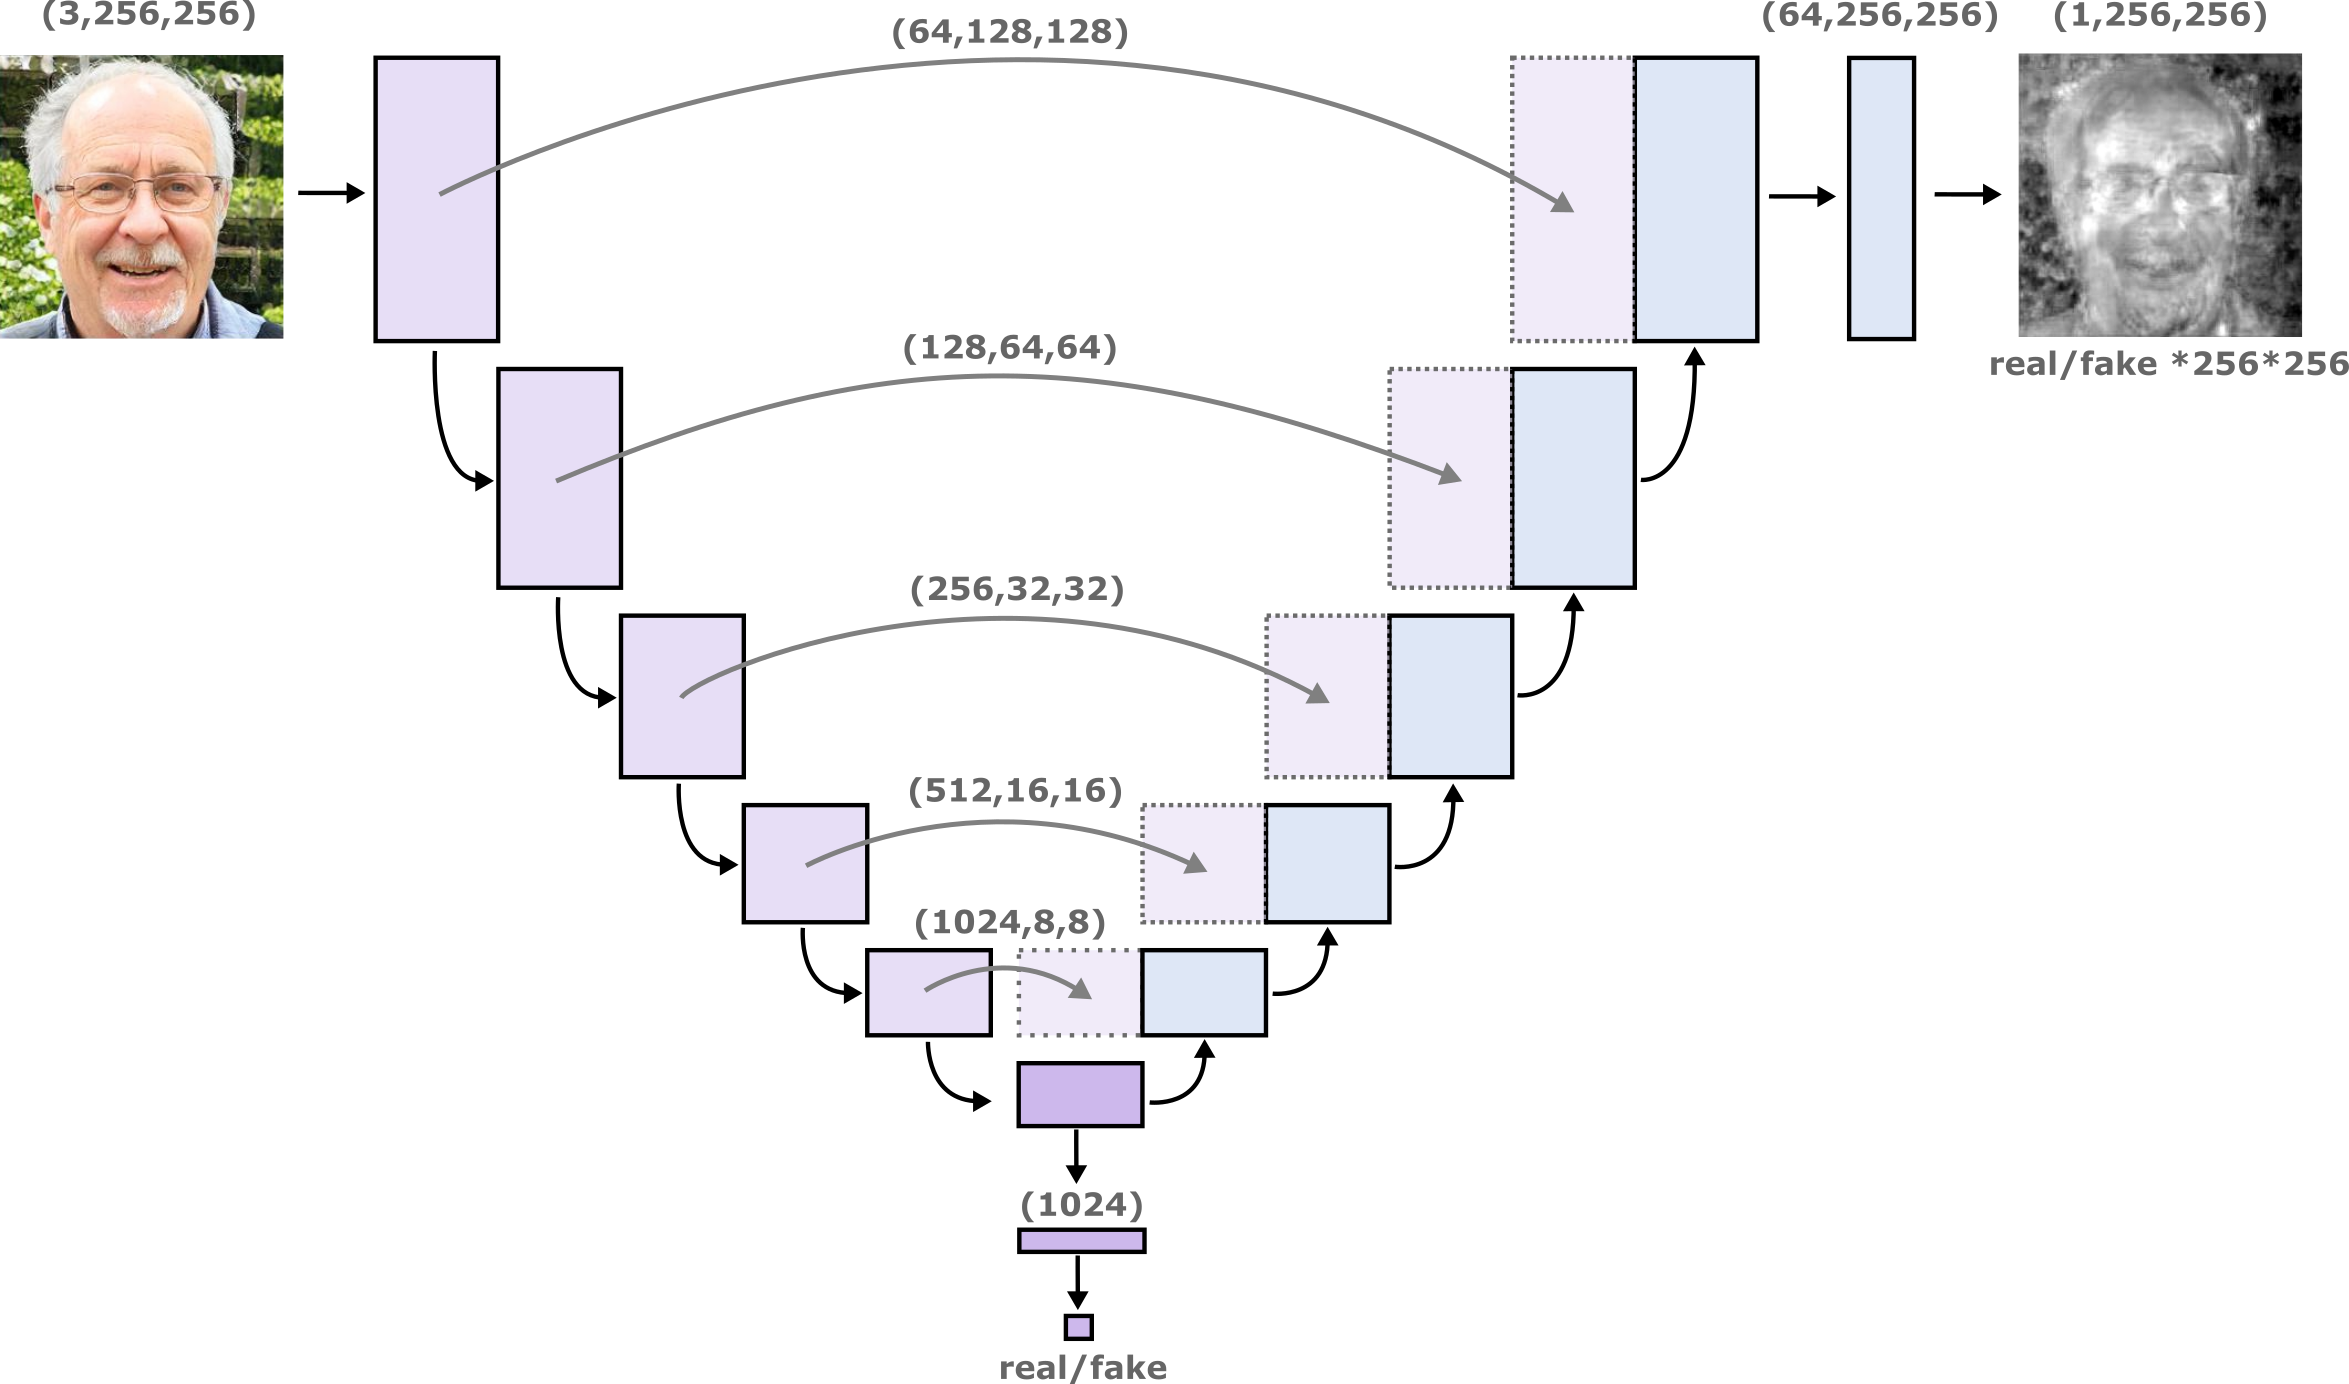

In [ ]:
def ResBlock(inputs, skipConnection,  NumberOfOutputChannel):
  if skipConnection == None:
    path1 = inputs
    path2 = inputs
  else:  
    concat = tf.keras.layers.Concatenate(axis = -1)([inputs, skipConnection])
    path1 = concat
    path2 = concat

  #1x1 conv to adapt number of channels!
  path1 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (1,1), padding = 'same', kernel_initializer = KERNEL_INIT)(path1)

  path2 = tf.keras.layers.Activation('relu')(path2)
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), padding = 'same', kernel_initializer = KERNEL_INIT)(path2)
  path2 = tf.keras.layers.Activation('relu')(path2)
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), padding = 'same', kernel_initializer = KERNEL_INIT)(path2)
  
  output = tf.keras.layers.Add()([path1, path2])

  return output

#input = tf.keras.layers.Input(shape=IMG_SIZE)
#skip = tf.keras.layers.Input(shape=IMG_SIZE)
#skip = None

#if skip == None:
#  inputs = input
#else:
#  inputs = [input, skip]

#model = tf.keras.Model(inputs=inputs, outputs=ResBlock(input,skip, 1))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)
#del input, skip, model

Idea: Large Scale GAN Training for High Fidelity Natural Image Synthesis, http://arxiv.org/abs/1809.11096

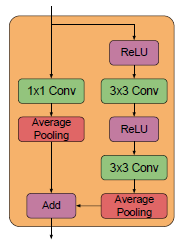

In [ ]:
def ResBlockDown(inputs, NumberOfOutputChannel):
  path1 = inputs
  path2 = inputs

  path1 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (1,1), padding = 'same', kernel_initializer = KERNEL_INIT)(path1)
  path1 = tf.keras.layers.AveragePooling2D()(path1)

  path2 = tf.keras.layers.Activation('relu')(path2)
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), padding = 'same', kernel_initializer = KERNEL_INIT)(path2)
  path2 = tf.keras.layers.Activation('relu')(path2)
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), padding = 'same', kernel_initializer = KERNEL_INIT)(path2)
  path2 = tf.keras.layers.AveragePooling2D()(path2)
  
  output = tf.keras.layers.Add()([path1, path2])

  return output

#input = tf.keras.layers.Input(shape=IMG_SIZE)
#model = tf.keras.Model(inputs=input, outputs=ResBlockDown(input, 8))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)
#del input, model

Idea: Large Scale GAN Training for High Fidelity Natural Image Synthesis, http://arxiv.org/abs/1809.11096

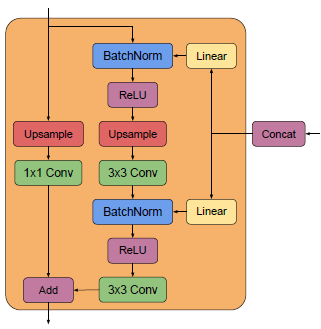

In [ ]:
def ResBlockUp(inputs, skipConnection, NumberOfOutputChannel):
  
  if skipConnection == None:
    path1 = inputs
    path2 = inputs
  else:  
    concat = tf.keras.layers.Concatenate(axis = -1)([inputs, skipConnection])
    path1 = concat
    path2 = concat

  path1 = tf.keras.layers.UpSampling2D()(path1)
  path1 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (1,1), padding = 'same', kernel_initializer = KERNEL_INIT)(path1)

  path2 = tf.keras.layers.BatchNormalization()(path2)
  path2 = tf.keras.layers.Activation('relu')(path2)
  path2 = tf.keras.layers.UpSampling2D()(path2)
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), padding = 'same', kernel_initializer = KERNEL_INIT)(path2)
  path2 = tf.keras.layers.BatchNormalization()(path2)
  path2 = tf.keras.layers.Activation('relu')(path2)
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), padding = 'same', kernel_initializer = KERNEL_INIT)(path2)

  output = tf.keras.layers.Add()([path1, path2])

  return output

#input = tf.keras.layers.Input(shape=IMG_SIZE))
#skip = tf.keras.layers.Input(shape=IMG_SIZE)
#skip = None

#if skip == None:
#  inputs = input
#else:
#  inputs = [input, skip]

#model = tf.keras.Model(inputs=inputs, outputs=ResBlockUp(input,skip, 4))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)
#del input, skip, model

Non-Local Block Paper: https://arxiv.org/pdf/1711.07971.pdf

Implementation based on Code: https://github.com/Tramac/Non-local-tensorflow/blob/master/non_local/non_local_dot_product.py

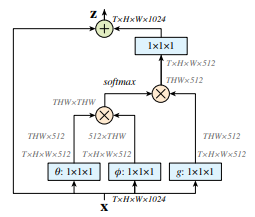

In [ ]:
def NonLocalBlock(inputs):
  numChannel = K.int_shape(inputs)[-1]
  batchSize, height, width = tf.shape(inputs)[0:3]

  intermediateChannel = int(numChannel/2)

  theta = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), padding = 'same', kernel_initializer = KERNEL_INIT)(inputs)
  theta = tf.keras.layers.Reshape(target_shape=(-1, intermediateChannel))(theta)

  phi = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), padding = 'same', kernel_initializer = KERNEL_INIT)(inputs)
  phi = tf.keras.layers.MaxPooling2D()(phi)
  phi = tf.keras.layers.Reshape(target_shape=(intermediateChannel, -1))(phi)

  g = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), padding = 'same', kernel_initializer = KERNEL_INIT)(inputs)
  g = tf.keras.layers.MaxPooling2D()(g)
  g = tf.keras.layers.Reshape(target_shape=(-1, intermediateChannel))(g)

  theta_phi = tf.matmul(theta, phi)
  theta_phi = tf.keras.layers.Activation('softmax')(theta_phi)

  theta_phi_g = tf.matmul(theta_phi, g)
  #theta_phi_g = tf.keras.layers.Lambda(tf.matmul)([theta_phi, g])
  theta_phi_g = tf.reshape(theta_phi_g, (batchSize, height, width, intermediateChannel))

  theta_phi_g = tf.keras.layers.Conv2D(filters = intermediateChannel * 2, kernel_size = (1,1), padding = 'same', kernel_initializer = KERNEL_INIT)(theta_phi_g)
  theta_phi_g = tf.keras.layers.BatchNormalization()(theta_phi_g)
  z = tf.keras.layers.Add()([theta_phi_g, inputs])

  return z


#input = tf.keras.layers.Input(shape=IMG_SIZE)

#model = tf.keras.Model(inputs=input, outputs=NonLocalBlock(input))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
#del input, model

In [ ]:
def UNetDiscriminator(inputShape = IMG_SIZE, n_filters = 8, useNonLocalBlock = False, name = None):
  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)

  # increase channelwidth from 4 -> Channels
  d0 = tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(3,3),padding='same')(input_tensor) #Taken from the biggan paper, not roperly described in the U-Net Discriminator paper
  
  # Down Blocks
  d1 = ResBlockDown(d0, NumberOfOutputChannel =  n_filters * 2)
  d2 = ResBlockDown(d1, NumberOfOutputChannel =  n_filters * 4)
  if useNonLocalBlock:
    d2 = NonLocalBlock(d2)
  d3 = ResBlockDown(d2, NumberOfOutputChannel =  n_filters * 8)
  d4 = ResBlockDown(d3, NumberOfOutputChannel =  n_filters * 8)
  d5 = ResBlockDown(d4, NumberOfOutputChannel =  n_filters * 16) 

  # Real/Fake Output
  y = tf.keras.activations.relu(d5)
  y = tf.keras.layers.GlobalAveragePooling2D()(y) #ACHTUNG: PAPER SAGT EIG GLOBAL SUM POOLING!!! 
  out1 = tf.keras.layers.Dense(1)(y)

  # Up Blocks
  u5 = ResBlockUp(d5, skipConnection = None, NumberOfOutputChannel = n_filters * 8)
  u4 = ResBlockUp(u5, skipConnection = d4, NumberOfOutputChannel =  n_filters * 8)
  u3 = ResBlockUp(u4, skipConnection = d3, NumberOfOutputChannel =  n_filters * 4)
  u2 = ResBlockUp(u3, skipConnection = d2, NumberOfOutputChannel =  n_filters * 2)
  u1 = ResBlockUp(u2, skipConnection = d1, NumberOfOutputChannel =  n_filters)

  #Residual Blocks
  r1 = ResBlock(u1, skipConnection = d0, NumberOfOutputChannel =  n_filters)
  final = tf.keras.layers.Conv2D(filters = 1, kernel_size = (1,1), padding = 'same', kernel_initializer = KERNEL_INIT)(r1)

  # Real / Fake Pixel Segmentation
  out2 = tf.keras.activations.sigmoid(final)

  return tf.keras.Model(inputs=input_tensor, outputs=[out1, out2], name = name)

# Test Code
#model = UNetDiscriminator(inputShape = IMG_SIZE, name = "ResNet")
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

#dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset
# swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
#rgbd_synthetic, _ = np.einsum('dshwc->sdhwc', dataset)

#img = rgbd_synthetic[0,...]
#Plot_RGBD_Sample(img, title="Discriminator Input Image")
#encoder_Output, decoder_Output = model(img[tf.newaxis,...], training = False)
#plt.imshow(decoder_Output[0,...,-1], cmap='RdBu_r')
#plt.colorbar()
#print("Encoder Output Prediction: {}".format(encoder_Output))
#del model#, img, encoder_Output, decoder_Output

<a name="4-4-5"></a>
### 4.4.5 CycleGAN

> Idea taken from: CycleGAN implementation of TensorFlow: https://www.tensorflow.org/tutorials/generative/cyclegan

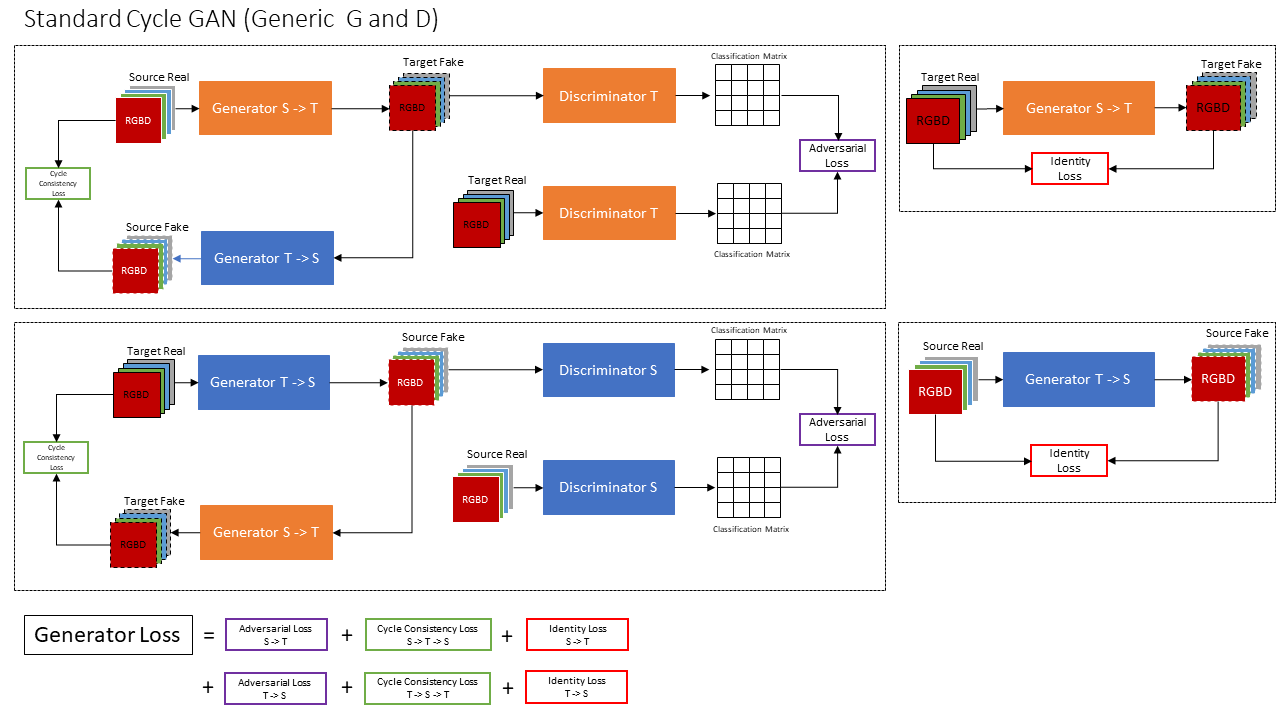

In [ ]:
class CycleGAN(tf.keras.Model):
  def __init__(self, generator_T, generator_S, discriminator_S, discriminator_T, lambda_cycle=10.0, lambda_identity=0.2):
    super(CycleGAN, self).__init__()
    
    self.modelType = "CycleGAN"
    self.generator_S_to_T = generator_T
    self.generator_T_to_S = generator_S
    self.discriminator_S = discriminator_S
    self.discriminator_T = discriminator_T
    self.lambda_cycle = lambda_cycle
    self.lambda_identity = lambda_identity

  def compile(self, generator_S_to_T_optimizer, generator_T_to_S_optimizer, discriminator_S_optimizer, discriminator_T_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
    super(CycleGAN, self).compile()
    self.generator_S_to_T_optimizer = generator_S_to_T_optimizer
    self.generator_T_to_S_optimizer = generator_T_to_S_optimizer
    self.discriminator_S_optimizer = discriminator_S_optimizer
    self.discriminator_T_optimizer = discriminator_T_optimizer
    self.generator_loss_fn = gen_loss_fn
    self.discriminator_loss_fn = disc_loss_fn
    self.cycle_loss_fn = cycle_loss_fn
    self.identity_loss_fn = identity_loss_fn

  def call(self, input_S, input_T):
    generated_T = self.generator_S_to_T(input_S)
    generated_S = self.generator_T_to_S(input_T)
    discriminated_T = self.discriminator_T(input_T)
    discriminated_S = self.discriminator_S(input_S)
    return tf.stack([generated_T, generated_S, discriminated_T, discriminated_S])

  def build_model_from_layers(self, shape):
    x = tf.keras.layers.Input(shape=(shape))
    y = tf.keras.layers.Input(shape=(shape))
    return tf.keras.Model(inputs=[x, y], outputs=self.call(x, y))


  def print_summary(self):

    def getNumberOfElements(listOfLayers):
      numElements = 0
      for layer in listOfLayers:
        numElements += tf.reduce_prod(layer.shape)
      return numElements

    summaryString = ""
    summaryString += "--------------------------------------------------\n"
    summaryString += "---------------- Summary Cycle GAN ---------------\n"
    summaryString += "--------------------------------------------------\n"
    
    summaryString += "\n"
    summaryString += self.generator_S_to_T.name + ":\n"
    gen1_total = getNumberOfElements(self.generator_S_to_T.variables)
    gen1_trainable = getNumberOfElements(self.generator_S_to_T.trainable_variables)
    gen1_nonTrainable = gen1_total - gen1_trainable
    summaryString += "  Total Variables: {:,}\n".format(gen1_total)
    summaryString += "  Trainable Variables: {:,}\n".format(gen1_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(gen1_nonTrainable)

    summaryString += "\n"
    summaryString += self.generator_T_to_S.name + ":\n"
    gen2_total = getNumberOfElements(self.generator_T_to_S.variables)
    gen2_trainable = getNumberOfElements(self.generator_T_to_S.trainable_variables)
    gen2_nonTrainable = gen2_total - gen2_trainable
    summaryString += "  Total Variables: {:,}\n".format(gen2_total)
    summaryString += "  Trainable Variables: {:,}\n".format(gen2_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(gen2_nonTrainable)

    summaryString += "\n"
    summaryString += self.discriminator_T.name + ":\n"
    disc1_total = getNumberOfElements(self.discriminator_T.variables)
    disc1_trainable = getNumberOfElements(self.discriminator_T.trainable_variables)
    disc1_nonTrainable = disc1_total - disc1_trainable
    summaryString += "  Total Variables: {:,}\n".format(disc1_total)
    summaryString += "  Trainable Variables: {:,}\n".format(disc1_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(disc1_nonTrainable)

    summaryString += "\n"
    summaryString += self.discriminator_S.name + ":\n"
    disc2_total = getNumberOfElements(self.discriminator_S.variables)
    disc2_trainable = getNumberOfElements(self.discriminator_S.trainable_variables)
    disc2_nonTrainable = disc2_total - disc2_trainable
    summaryString += "  Total Variables: {:,}\n".format(disc2_total)
    summaryString += "  Trainable Variables: {:,}\n".format(disc2_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(disc2_nonTrainable)

    summaryString += "_________________________________________________\n"

    cycleGAN_total = gen1_total + gen2_total + disc1_total + disc2_total
    cycleGAN_trainable = gen1_trainable + gen2_trainable + disc1_trainable + disc2_trainable
    cycleGAN_nonTrainable = gen1_nonTrainable + gen2_nonTrainable + disc1_nonTrainable + disc2_nonTrainable
    summaryString += "Total Variables: {:,}\n".format(cycleGAN_total)
    summaryString += "Trainable Variables: {:,}\n".format(cycleGAN_trainable)
    summaryString += "Non-trainable Variables: {:,}\n".format(cycleGAN_nonTrainable)

    summaryString += "_________________________________________________\n"

    print(summaryString)

    return summaryString

  def train_step(self, batch_train):
    real_S, real_T = batch_train

    # For CycleGAN, we need to calculate different
    # kinds of losses for the generators and discriminators.
    # We will perform the following steps here:
    #
    # 1. Pass real images through the generators and get the generated images
    # 2. Pass the generated images back to the generators to check if we
    #    we can predict the original image from the generated image.
    # 3. Do an identity mapping of the real images using the generators.
    # 4. Pass the generated images in 1) to the corresponding discriminators.
    # 5. Calculate the generators total loss (adverserial + cycle + identity)
    # 6. Calculate the discriminators loss
    # 7. Update the weights of the generators
    # 8. Update the weights of the discriminators
    # 9. Return the losses in a dictionary

    with tf.GradientTape(persistent=True) as tape:
      # Synthetic to target domain
      generated_T = self.generator_S_to_T(real_S, training=True)
      # target to synthetic domain
      generated_S = self.generator_T_to_S(real_T, training=True)

      # Cycle synthetic -> target -> synthetic
      cycled_S = self.generator_T_to_S(generated_T, training=True)
      # Cycle target -> synthetic -> target
      cycled_T = self.generator_S_to_T(generated_S, training=True)

      # Identity mapping
      same_S = self.generator_T_to_S(real_S, training=True)
      same_T = self.generator_S_to_T(real_T, training=True)

      if DISCRIMINATOR_DESIGN == 'UNet':
        # Discriminator output
        disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=True)
        disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=True)

        disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=True)
        disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=True)

        # Discriminator loss
        discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_encoder, disc_real_S_decoder, disc_generated_S_encoder, disc_generated_S_decoder)
        discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_encoder, disc_real_T_decoder, disc_generated_T_encoder, disc_generated_T_decoder)

        # Generator adverserial loss
        generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_encoder, disc_generated_T_decoder)
        generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_encoder, disc_generated_S_encoder)
      
      else:
        # Discriminator output
        disc_real_S = self.discriminator_S(real_S, training=True)
        disc_generated_S = self.discriminator_S(generated_S, training=True)

        disc_real_T = self.discriminator_T(real_T, training=True)
        disc_generated_T = self.discriminator_T(generated_T, training=True)

        # Discriminator loss
        discriminator_S_loss = self.discriminator_loss_fn(disc_real_S, disc_generated_S)
        discriminator_T_loss = self.discriminator_loss_fn(disc_real_T, disc_generated_T)

        # Generator adverserial loss
        generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T)
        generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S)

      # Generator cycle loss
      cycle_loss_T = self.cycle_loss_fn(real_T, cycled_T) * self.lambda_cycle
      cycle_loss_S = self.cycle_loss_fn(real_S, cycled_S) * self.lambda_cycle

      # Generator identity loss
      id_loss_T = self.identity_loss_fn(real_T, same_T) * self.lambda_identity
      id_loss_S = self.identity_loss_fn(real_S, same_S) * self.lambda_identity

      # Total generator loss
      total_gen_loss_T = generator_S_to_T_loss + cycle_loss_T + id_loss_T
      total_gen_loss_S = generator_T_to_S_loss + cycle_loss_S + id_loss_S

    # Get the gradients for the generators
    grads_T = tape.gradient(total_gen_loss_T, self.generator_S_to_T.trainable_variables)
    grads_S = tape.gradient(total_gen_loss_S, self.generator_T_to_S.trainable_variables)

    # Get the gradients for the discriminators
    discriminator_S_grads = tape.gradient(discriminator_S_loss, self.discriminator_S.trainable_variables)
    discriminator_T_grads = tape.gradient(discriminator_T_loss, self.discriminator_T.trainable_variables)

    # Update the weights of the generators
    self.generator_S_to_T_optimizer.apply_gradients(
      zip(grads_T, self.generator_S_to_T.trainable_variables)
    )
    self.generator_T_to_S_optimizer.apply_gradients(
      zip(grads_S, self.generator_T_to_S.trainable_variables)
    )

    # Update the weights of the discriminators
    self.discriminator_S_optimizer.apply_gradients(
      zip(discriminator_S_grads, self.discriminator_S.trainable_variables)
    )
    self.discriminator_T_optimizer.apply_gradients(
      zip(discriminator_T_grads, self.discriminator_T.trainable_variables)
    )

    return [total_gen_loss_T, total_gen_loss_S, discriminator_T_loss, discriminator_S_loss]
    

  def test_step(self, batch_test):
    real_S, real_T = batch_test

    # Synthetic to target domain
    generated_T = self.generator_S_to_T(real_S, training=False)
    # target to synthetic domain
    generated_S = self.generator_T_to_S(real_T, training=False)

    # Cycle synthetic -> target -> synthetic
    cycled_S = self.generator_T_to_S(generated_T, training=False)
    # Cycle target -> synthetic -> target
    cycled_T = self.generator_S_to_T(generated_S, training=False)

    # Identity mapping
    same_S = self.generator_T_to_S(real_S, training=False)
    same_T = self.generator_S_to_T(real_T, training=False)

    if DISCRIMINATOR_DESIGN == 'UNet':
      # Discriminator output
      disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=False)
      disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=False)

      disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=False)
      disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=False)

      # Discriminator loss
      discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_encoder, disc_real_S_decoder, disc_generated_S_encoder, disc_generated_S_decoder)
      discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_encoder, disc_real_T_decoder, disc_generated_T_encoder, disc_generated_T_decoder)

      # Generator adverserial loss
      generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_encoder, disc_generated_T_decoder )
      generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_encoder, disc_generated_S_encoder)
    
    else:
      # Discriminator output
      disc_real_S = self.discriminator_S(real_S, training=False)
      disc_generated_S = self.discriminator_S(generated_S, training=False)

      disc_real_T = self.discriminator_T(real_T, training=False)
      disc_generated_T = self.discriminator_T(generated_T, training=False)

      # Discriminator loss
      discriminator_S_loss = self.discriminator_loss_fn(disc_real_S, disc_generated_S)
      discriminator_T_loss = self.discriminator_loss_fn(disc_real_T, disc_generated_T)

      # Generator adverserial loss
      generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T)
      generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S)

    # Generator cycle loss
    cycle_loss_T = self.cycle_loss_fn(real_T, cycled_T) * self.lambda_cycle
    cycle_loss_S = self.cycle_loss_fn(real_S, cycled_S) * self.lambda_cycle

    # Generator identity loss
    id_loss_T = self.identity_loss_fn(real_T, same_T) * self.lambda_identity
    id_loss_S = self.identity_loss_fn(real_S, same_S) * self.lambda_identity

    # Total generator loss
    total_gen_loss_T = generator_S_to_T_loss + cycle_loss_T + id_loss_T
    total_gen_loss_S = generator_T_to_S_loss + cycle_loss_S + id_loss_S

    return [total_gen_loss_T, total_gen_loss_S, discriminator_T_loss, discriminator_S_loss]


  #IDEA OF THIS METHOD: Show input and output of the generators, show the classification of the discriminator
  def ShowInferenceValidation(self, real_S, real_T):

    # Synthetic to target domain
    generated_T = cycleGAN.generator_S_to_T(real_S, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = generated_T[0,...], writeToTensorboard = False, title = "Synthetic -> Target")

    # target to synthetic domain
    generated_S = cycleGAN.generator_T_to_S(real_T, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = generated_S[0,...], writeToTensorboard = False, title = "Target -> Synthetic")

    # Cycle synthetic -> target -> synthetic
    cycled_S = cycleGAN.generator_T_to_S(generated_T, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = cycled_S[0,...], writeToTensorboard = False, title = "Synthetic -> Target -> Synthetic")

    # Cycle target -> synthetic -> target
    cycled_T = cycleGAN.generator_S_to_T(generated_S, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = cycled_T[0,...], writeToTensorboard = False, title = "Target -> Synthetic -> Target")

    # Identity mapping Synthetic -> Synthetic
    same_S = cycleGAN.generator_T_to_S(real_S, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = same_S[0,...], writeToTensorboard = False, title = "Synthetic -> Synthetic")

    # Identity mapping Target -> Target
    same_T = cycleGAN.generator_S_to_T(real_T, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = same_T[0,...], writeToTensorboard = False, title = "Target -> Target")

    if DISCRIMINATOR_DESIGN == 'UNet':
      # Discriminator output
      disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=False)
      Plot_discriminator_prediction(real_S.astype(np.float32)[0,...], disc_real_S_decoder,"Synthetic Discriminator Real Synthetic Input")

      disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=False)
      Plot_discriminator_prediction(generated_S[0,...], disc_generated_S_decoder,"Synthetic Discriminator Fake Synthetic Input")

      disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=False)
      Plot_discriminator_prediction(real_T.astype(np.float32)[0,...], disc_real_T_decoder,"Target Discriminator Real Target Input")

      disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=False)
      Plot_discriminator_prediction(generated_T[0,...], disc_generated_T_decoder,"Target Discriminator Fake Target Input")
    
    else:
      # Discriminator output
      disc_real_S = self.discriminator_S(real_S, training=False)
      Plot_discriminator_prediction(real_S.astype(np.float32)[0,...], disc_real_S,"Synthetic Discriminator Real Synthetic Input")

      disc_generated_S = self.discriminator_S(generated_S, training=False)
      Plot_discriminator_prediction(generated_S[0,...], disc_generated_S,"Synthetic Discriminator Fake Synthetic Input")

      disc_real_T = self.discriminator_T(real_T, training=False)
      Plot_discriminator_prediction(real_T.astype(np.float32)[0,...], disc_real_T,"Target Discriminator Real Target Input")

      disc_generated_T = self.discriminator_T(generated_T, training=False)
      Plot_discriminator_prediction(generated_T[0,...], disc_generated_T,"Target Discriminator Fake Target Input")

  def Generate(self):
    # Inference from fake to target
    # Inference from target to fake
    pass

  @tf.function
  def distributed_train_step(self, batch_train):
    ''' 
    per_replica_loss_vector:  vector of shape [per_replica-loss_gen1, per_replica-loss_gen2, per_replica-loss_disc1, per_replica-loss_disc1]
    reduced_loss_vector:      Vector of results of the different devices (for TPU 8)
    
    '''
    per_replica_loss_vector = strategy.run(self.train_step, args=(batch_train,))

    #reduce the result of the replicas for every loss value returned!
    reduced_loss_vector = []
    for per_replica_loss in per_replica_loss_vector:
      reduced_loss_vector.append(strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None))
    
    return reduced_loss_vector

  @tf.function
  def distributed_test_step(self, batch_test):
    ''' 
    per_replica_loss_vector:  vector of shape [per_replica-loss_gen1, per_replica-loss_gen2, per_replica-loss_disc1, per_replica-loss_disc1]
    reduced_loss_vector:      Vector of results of the different devices (for TPU 8)
    
    '''
    per_replica_loss_vector = strategy.run(self.test_step, args=(batch_test,))

    #reduce the result of the replicas for every loss value returned!
    reduced_loss_vector = []
    for per_replica_loss in per_replica_loss_vector:
      reduced_loss_vector.append(strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None))
    
    return reduced_loss_vector

  def Save_Submodels(self, cycleGAN_Name, baseDirectory = os.path.join(BASE_SAVE_DIRECTORY,"saved_models")):
    '''
    Saves each of the models containing the current weights.
    save_option is required to save models in distributed strategy with tpu othervise there is no acces to the local filesystem.
    '''
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    self.generator_T_to_S.save(os.path.join(baseDirectory, cycleGAN_Name, "generator_T_to_S"), options = save_options)
    self.generator_S_to_T.save(os.path.join(baseDirectory, cycleGAN_Name, "generator_S_to_T"), options = save_options)
    self.discriminator_S.save(os.path.join(baseDirectory, cycleGAN_Name, "discriminator_S"), options = save_options)
    self.discriminator_T.save(os.path.join(baseDirectory, cycleGAN_Name, "discriminator_T"), options = save_options)


  #def Load_Model(self, path_generator_S_to_T, path_generator_T_to_S, path_discriminator_T, path_discriminator_S, print_summary = False):
  #  '''
  #  loads each of the models containing the saved weights.
  #  load_option is required to save models in distributed strategy with tpu othervise there is no acces to the local filesystem.
  #  '''
  #  load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
  #  self.generator_S_to_T = tf.keras.models.load_model(path_generator_S_to_T, options=load_options)
  #  self.generator_T_to_S = tf.keras.models.load_model(path_generator_T_to_S, options=load_options)
  #  self.discriminator_T = tf.keras.models.load_model(path_discriminator_T, options=load_options)
  #  self.discriminator_S = tf.keras.models.load_model(path_discriminator_S, options=load_options)

  #  if print_summary:
  #    self.generator_S_to_T.summary()
  #    self.generator_T_to_S.summary()
  #    self.discriminator_T.summary()
  #    self.discriminator_S.summary()

  #def Save_Checkpoint(self, epoch):
    #self.generator_S_to_T.save_weights("generator_S_to_T")
    #self.generator_T_to_S.save_weights("generator_T_to_S")
    #self.discriminator_T.save_weights("discriminator_T")
    #self.discriminator_S.save_weights("discriminator_S")

  #def Load_Checkpoint(self, path_generator_S_to_T, path_generator_T_to_S, path_discriminator_T, path_discriminator_S):
  #  self.generator_S_to_T.load_weight(path_generator_S_to_T)
  #  self.generator_T_to_S.load_weight(path_generator_T_to_S)
  #  self.discriminator_T.load_weight(path_discriminator_T)
  #  self.discriminator_S.load_weight(path_discriminator_S)

<a name="4-3"></a>
## 4.3 Loss Functions

loss Reduction Explanation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/Reduction

Hinweis: 
- da in der methode:distributed_train_step() die reduction strategy "sum" ist, muss ich hier durch die globale Batch size teilen.

Comonly Loss Functions: https://phuctrt.medium.com/loss-functions-why-what-where-or-when-189815343d3f

Adversarial Loss:
- Use Mean absolute squared(MSE) error.
>$MSE = \frac{\sum_{i=1}^n(y_{i}-y_{i}^p)^2}{n}$

Identity Loss:
- Uses pixel distance. Idially there is no difference! MAE (Mean Absolute Error) is used. This is a regression loss function
>$MAE = \frac{\sum_{i=1}^n|y_{i}-y_{i}^p|}{n}$ = tf.reduce_mean(tf.abs(real - identity))

Cycle Loss:
- Uses pixel distance. Idially there is no difference! MAE (Mean Absolute Error) is used. This is a regression loss function
>$MAE = \frac{\sum_{i=1}^n|y_{i}-y_{i}^p|}{n}$ = tf.reduce_mean(tf.abs(real - cycled))

ACHTUNG: Im bezug auf die reduction strategy
-  tf.reduce_sum(loss) * (1/shape) = tf.reduce_mean(loss)



---
TODO:
- [ ] Check perceptional loss instead of pixel-per-pixel loss :
 - https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf
 - https://arxiv.org/abs/2012.04781
- [ ] The loss of the unet discriminator uses BCE Loss in the original paper


In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = tf.keras.losses.MeanSquaredError(reduction=REDUCTION_STRATEGY)

# Define the loss function for the generators
def generator_loss_fn(generated):
  gen_loss = adv_loss_fn(tf.ones_like(generated), generated)
  #manually reduce with reduce_sum and average with GLOBAL_BATCH_SIZE
  #shape = tf.size(gen_loss, tf.float32)
  #gen_loss = tf.reduce_sum(gen_loss) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape)
  gen_loss = tf.reduce_mean(gen_loss) * (1. / GLOBAL_BATCH_SIZE)
  return gen_loss

# Generator loss function for UNet based Discriminator
def generator_loss_fn_UNet_Disc(generatedEncoder, generatedDecoder):
  gen_loss_encoder = adv_loss_fn(tf.ones_like(generatedEncoder), generatedEncoder)
  gen_loss_decoder = adv_loss_fn(tf.ones_like(generatedDecoder), generatedDecoder)
  #manually reduce with reduce_sum and average with GLOBAL_BATCH_SIZE
  #shape_encoder_loss = tf.size(gen_loss_encoder, tf.float32)
  #shape_decoder_loss = tf.size(gen_loss_decoder, tf.float32)

  #gen_loss_encoder = tf.reduce_sum(gen_loss_encoder) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape_encoder_loss)
  #gen_loss_decoder = tf.reduce_sum(gen_loss_decoder) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape_decoder_loss)

  gen_loss_encoder = tf.reduce_mean(gen_loss_encoder) * (1. / GLOBAL_BATCH_SIZE) 
  gen_loss_decoder = tf.reduce_mean(gen_loss_decoder) * (1. / GLOBAL_BATCH_SIZE) 

  gen_loss = gen_loss_encoder + gen_loss_decoder

  return gen_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, generated):
  real_loss = adv_loss_fn(tf.ones_like(real), real)
  generated_loss = adv_loss_fn(tf.zeros_like(generated), generated)
  disc_loss = (real_loss + generated_loss) * 0.5
  #shape = tf.size(disc_loss, tf.float32)
  #disc_loss = tf.reduce_sum(disc_loss) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape)
  disc_loss = tf.reduce_mean(disc_loss) * (1. / GLOBAL_BATCH_SIZE) 
  return disc_loss

# Discriminator loss function for UNet based Discriminator
def discriminator_loss_fn_UNet_Disc(realEncoder, realDecoder, generatedEncoder, generatedDecoder):
  #calculate encoder loss
  real_loss_encoder = adv_loss_fn(tf.ones_like(realEncoder), realEncoder)
  gen_loss_encoder = adv_loss_fn(tf.zeros_like(generatedEncoder), generatedEncoder)
  disc_loss_encoder = (real_loss_encoder + gen_loss_encoder) * 0.5
  #shape_encoder_loss = tf.size(disc_loss_encoder, tf.float32)
  #disc_loss_encoder = tf.reduce_sum(disc_loss_encoder) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape_encoder_loss)
  disc_loss_encoder = tf.reduce_mean(disc_loss_encoder) * (1. / GLOBAL_BATCH_SIZE)

  #calculate decoder loss
  real_loss_decoder = adv_loss_fn(tf.ones_like(realDecoder), realDecoder)
  gen_loss_decoder = adv_loss_fn(tf.zeros_like(generatedDecoder), generatedDecoder)
  disc_loss_decoder = (real_loss_decoder + gen_loss_decoder) * 0.5
  #shape_decoder_loss = tf.size(disc_loss_decoder, tf.float32)
  #disc_loss_decoder = tf.reduce_sum(disc_loss_decoder) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape_decoder_loss)
  disc_loss_decoder = tf.reduce_mean(disc_loss_decoder) * (1. / GLOBAL_BATCH_SIZE) 

  #calculate disriminator loss
  disc_loss = disc_loss_encoder + disc_loss_decoder
  
  return disc_loss

#calculates the abs pixel distance between two images
def pixel_distance_loss(img1, img2):
  img1 = tf.cast(img1, tf.dtypes.float32)
  img2 = tf.cast(img2, tf.dtypes.float32)
  abs_diff = tf.abs(img1 - img2)
  #shape = tf.size(abs_diff, tf.float32)
  #pixel_distance_loss = tf.reduce_sum(abs_diff) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape)
  pixel_distance_loss = tf.reduce_mean(abs_diff) * (1. / GLOBAL_BATCH_SIZE) 
  return pixel_distance_loss

# Cycle Consistency Loss
def cycle_loss_fn(real, identity):
  return pixel_distance_loss(real, identity)

# Identity Loss 
def identity_loss_fn(real, same):
  return pixel_distance_loss(real, same)


<a name="5"></a>
# 5 - Training the Model

TODO:
- [ ] Define metrics


<a name="5-1"></a>
## 5.1 Model Preparation

In [ ]:
def getCycleGANModel():
  #Define Generator, based on Notebook Settings
  if GENERATOR_DESIGN == 'ResNet':
    generator_T = ResNet(inputShape = IMG_SIZE, name = "Generator_T_ResNet", useUpsampleLayer = False)
    generator_S = ResNet(inputShape = IMG_SIZE, name = "Generator_S_ResNet", useUpsampleLayer = False)
  elif GENERATOR_DESIGN == 'UNet':
    generator_T = UNet(inputShape = IMG_SIZE, number_of_layers = 3, useUpsampleLayer = True, n_filters = 64, useResidualBottleNeck = False,  name = "Generator_T_UNet")
    generator_S = UNet(inputShape = IMG_SIZE, number_of_layers = 3, useUpsampleLayer = True, n_filters = 64, useResidualBottleNeck = False,  name = "Generator_S_UNet")
  elif GENERATOR_DESIGN == 'UNet_risidual_bottleneck':
    generator_T = UNet(inputShape = IMG_SIZE, number_of_layers = 3, useUpsampleLayer = False, n_filters = 64, useResidualBottleNeck = True, numOfResidualLayers = 3, useBottleneckIdentity = True, name = "Generator_T_UNet_risidual_bottleneck")
    generator_S = UNet(inputShape = IMG_SIZE, number_of_layers = 3, useUpsampleLayer = False, n_filters = 64, useResidualBottleNeck = True, numOfResidualLayers = 3, useBottleneckIdentity = True, name = "Generator_S_UNet_risidual_bottleneck")
  else:
    raise Exception("Generator is not Defined")
  
  #Define Discriminator, based on Notebook Settings
  if DISCRIMINATOR_DESIGN == 'PatchGAN':
    discriminator_T = PatchGAN(inputShape = IMG_SIZE, name = "Discriminator_T_PatchGAN")
    discriminator_S = PatchGAN(inputShape = IMG_SIZE, name = "Discriminator_S_PatchGAN")
  elif DISCRIMINATOR_DESIGN == 'UNet':
    discriminator_T = UNetDiscriminator(inputShape = IMG_SIZE, useNonLocalBlock = False, name = "Discriminator_T_UNet")
    discriminator_S = UNetDiscriminator(inputShape = IMG_SIZE, useNonLocalBlock = False, name = "Discriminator_S_UNet")
  else:
    raise Exception("Discriminator is not Defined")

  return CycleGAN(generator_T, generator_S, discriminator_T, discriminator_S )

Model needs to be created with in strategy.scope(). In that way, all variables are created on all devices. The Model is not stored at the CPU, but the TPU cluster! Therefore the Model can not be saved in the VM File system, since this is running on the CPU.
https://www.tensorflow.org/guide/tpu 

Optimizer to evaluate!:
- SGD (stochastic gradient descent) with momentum
- RMSProp
- ADAM

In [ ]:
with strategy.scope():
  cycleGAN = getCycleGANModel()
  summaryString = cycleGAN.print_summary()
  if TENSORBOARD_TRAINING or TENSORBOARD_MODEL_GRAPH or TENSORBOARD_PERFORMANCE_PROFILE:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME)).as_default():
        tf.summary.text("Model Summary", step = 0, data = summaryString)

# Compile Model
if DISCRIMINATOR_DESIGN == 'UNet':
  gen_loss_fn = generator_loss_fn_UNet_Disc
  disc_loss_fn = discriminator_loss_fn_UNet_Disc
else:
  gen_loss_fn = generator_loss_fn
  disc_loss_fn = discriminator_loss_fn

cycleGAN.compile(
  generator_S_to_T_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
  generator_T_to_S_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
  discriminator_T_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
  discriminator_S_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
  gen_loss_fn = gen_loss_fn,
  disc_loss_fn = disc_loss_fn,
  cycle_loss_fn = cycle_loss_fn,
  identity_loss_fn = identity_loss_fn
)

# Prepare the checkpoint
if USE_CHECKPOINTS:
  checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')

  ckpt_cycleGAN = tf.train.Checkpoint(
      optimizer_generator_T_to_S = cycleGAN.generator_T_to_S_optimizer, 
      optimizer_generator_S_to_T = cycleGAN.generator_S_to_T_optimizer, 
      optimizer_discriminator_S = cycleGAN.discriminator_S_optimizer, 
      optimizer_discriminator_T = cycleGAN.discriminator_T_optimizer, 
      model_generator_T_to_S = cycleGAN.generator_T_to_S,
      model_generator_S_to_T = cycleGAN.generator_S_to_T,
      model_discriminator_S = cycleGAN.discriminator_S,
      model_discriminator_T = cycleGAN.discriminator_T,
      )


--------------------------------------------------
---------------- Summary Cycle GAN ---------------
--------------------------------------------------

Generator_T_UNet:
  Total Variables: 5,608,196
  Trainable Variables: 5,608,196
  Non-trainable Variables: 0

Generator_S_UNet:
  Total Variables: 5,608,196
  Trainable Variables: 5,608,196
  Non-trainable Variables: 0

Discriminator_S_PatchGAN:
  Total Variables: 74,409
  Trainable Variables: 74,153
  Non-trainable Variables: 256

Discriminator_T_PatchGAN:
  Total Variables: 74,409
  Trainable Variables: 74,153
  Non-trainable Variables: 256
_________________________________________________
Total Variables: 11,365,210
Trainable Variables: 11,364,698
Non-trainable Variables: 512
_________________________________________________



Metrics: https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [ ]:
#train_metric = tf.keras.metrics.MeanSquaredError()

<a name="5-2"></a>
## 5.2 Training Loop



TPU KAnn scheinbar nicht auf Lokalen Pfad zugreifen sondern nur über cloud storage! : https://cloud.google.com/tpu/docs/storage-buckets?hl=de#gsutil 


---



**Gedanke:**

Die TPU kann nicht drauf zu greifen, da die VM auf der CPU läuft, und diese lediglich das Training auf der TPU beauftragt... Die CPU agiert jedoc auch als Parameter Server während dem traing. demnach müsste das model auf der CPU verfügbarsein und deshalb kann man ggf. das model trotzdem speichern...
Tha means I could not save checkpoints on the harddisk during training, but I could save the model afterwards...


---


**Idea:**

Ich schreibe einen Try error block, der einen checkpoint erstellt, sollte etwas schief gehen. GGf. kann man erkennen, wenn die runtime disconected wird... 


---


**Fortschritt:**
- Es sieht so aus als könnte man checkpoints (nur die weigths) speichern. Ich denke das liegt daran, das das model ein distributed model wird, da man es im scope der TPU definiert hat... Die CPU agiert als PArameter server, so die aktuellen weights werden auf der CPU zusammengeführt. Da das model auf der TPU liegt, kann man dieses nicht speichern, da die TPU keinen zugriff auf das filesystem der CPU hat. 
- Neue Idee: 
  - Training des models und speichern der weigths.
  - Nach dem training ein neues Model erstellen im Scope der CPU
  - Initialisieren mit den Weigths der Weigths vom Training
  - Model Speichern im h5 Format.

- Beobachtung: 


```python
#funktioniert
cycleGAN.generator_T_to_S.save_weights("my_weights")

#Error that local file system not accessable...
cycleGAN.Save_Model_Weights("my_weights")
```
  - Meine Interpretation: 
    - das cycle gan und somit seine methoden können nicht aufgerufen werden, seine attribute aber schon....
    - man kan die save_weights methode nur einmal ausführen... ggf. einfach über den bucket gehen und fertig...



---

TODO:
- [ ] check: Improving performance by multiple steps within tf.function: https://www.tensorflow.org/guide/tpu
- [ ] Plot an image of the test after x epochs



In [ ]:
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  with strategy.scope():
      print("Starting training strategy...")
      print("Prepareing distributed datasets...")
      train_distributed, _ = get_distributed_Datasets(trainDataset, testDataset)

      print(train_distributed)

      dataset = list(train_distributed.take(1).as_numpy_iterator())[0]
      print(np.shape(dataset)) #(num_batches, target_synth, batch_size, height, width, channel)
      del train_distributed

      train_synthetic, train_target = dataset
      del dataset
      print(np.shape(train_synthetic))
      print(np.shape(train_target))

      Plot_RGBD_Seperatly(train_synthetic[0,...], title = "Target Domain RGBD Example")
      Plot_RGBD_Seperatly(train_target[0,...], title = "Target Domain RGBD Example")

      generated_T = cycleGAN.generator_S_to_T(train_synthetic)
      Plot_generator_prediction(input = train_synthetic.astype(np.float32)[0,...], prediction = generated_T[0,...], title = "Synthetic -> Target")

      del generated_T, train_synthetic

      generated_S = cycleGAN.generator_T_to_S(train_target)
      Plot_generator_prediction(input = train_target.astype(np.float32)[0,...], prediction = generated_S[0,...], title = "Target -> Synthetic")

      del generated_S, train_target
  #testcode
  %load_ext tensorboard
  %tensorboard --reload_interval 15 --logdir $BASE_SAVE_DIRECTORY/logs/ 
  with tf.device('/job:localhost'): 
    with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME,"train")).as_default():
      tf.summary.scalar("Generator S -> T Loss", data = 1, step = 3, description="This parameter represents the total loss of the generator ( adv + identity + cycle)")
      tf.summary.text("Test_Text_Name", data = cycleGAN.print_summary(), step = 0, description="This is the discription for the test text")

TODO:
- [ ] add TPU support for distributed dataset. distributed datasets dont have method take....
- [ ] add infos of the dataset to tensorboard
- [ ] add infos on lossfunctions, andoptimizers to tensorboard
- [ ] add info regarding training time to tensorboard

In [ ]:
#with strategy.scope():
#  dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset
#  print(np.shape(dataset)) #(num_batches, target_synth, batch_size, height, width, channel)

#  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
#  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

#  print(np.shape(rgbd_synthetic))
#  print(np.shape(rgbd_target))

#  generated_T = cycleGAN.generator_S_to_T(rgbd_synthetic)
#  Plot_generator_prediction(input = rgbd_synthetic.astype(np.float32)[0,...], prediction = generated_T[0,...], title = "Synthetic -> Target", writeToTensorboard = True, epoch = 4 )

#  generated_S = cycleGAN.generator_T_to_S(rgbd_target)
#  Plot_generator_prediction(input = rgbd_target.astype(np.float32)[0,...], prediction = generated_S[0,...], title = "Target -> Synthetic", writeToTensorboard = True, epoch = 4 )

In [ ]:
#%%monitor_cell “MasterThesis/TrainingLoop”
def fit_model(epochs = EPOCHS,
              training_validation = TRAINING_VALIDATION,
              tensorboard_training = TENSORBOARD_TRAINING,
              tensorboard_model_graph = TENSORBOARD_MODEL_GRAPH,
              tensorboard_performance_profile = TENSORBOARD_PERFORMANCE_PROFILE,
              epoch_to_profile = EPOCH_TO_PROFILE,
              use_checkpoints = USE_CHECKPOINTS,
              checkpoint_epoch_frequency = CHECKPOINT_EPOCH_FREQUENCY,
              save_models = SAVE_MODELS,
              return_train_loss = False, 
              return_test_loss = False
              ):
  
  with strategy.scope():
    print("Starting training strategy...")
    print("Prepareing distributed datasets...")
    train_distributed, test_distributed = get_distributed_Datasets(trainDataset, testDataset)

    train_batches_per_epoch = int(len(trainDataset)/GLOBAL_BATCH_SIZE)
    test_batches_per_epoch = int(len(testDataset)/GLOBAL_BATCH_SIZE)
    
    # start training timer
    training_start_time = time.time()
    print("Start trainings loop...")

    for epoch in range(epochs):

      # start epoch timer
      epoch_start_time = time.time()

      # initialize training parameter
      total_train_loss = [0., 0., 0., 0.]
      num_train_batches = 0

      # Start traceing Modelgraph
      if epoch == 0 and tensorboard_model_graph:
        print('Start tracing model graph')
        tf.summary.trace_on(graph=True, profiler=False)

      # start profiling performance
      if epoch == epoch_to_profile and tensorboard_performance_profile:
        print('Start profiling')
        tf.profiler.experimental.start(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME,"trace"))

      # Run distributed training
      for batch_train in train_distributed:
        total_train_loss = tf.math.add(total_train_loss, cycleGAN.distributed_train_step(batch_train))
        num_train_batches += 1
        print("\rT: Epoch: {} of {}. Batch: {} of {}. ".format((epoch+1) , epochs, num_train_batches, train_batches_per_epoch), end= "")

      # average over all batches in the current epoch
      total_train_loss = total_train_loss / float(num_train_batches)

      # calculate training time
      epoch_time = round(time.time() - epoch_start_time, 3)
      training_time = round(time.time() - training_start_time, 3)
      print("\rT: Epoch: {0:5} of {1:5}. Duration Epoch: {2:.3f} sec, Duration Training: {3:.3f} sec, Loss Gen_S_to_T = {4:.6f}, Loss Gen_T_to_S = {5:.6f}, Loss Disc_T = {6:.6f}, Loss Disc_S = {7:.6f}".format((epoch+1), epochs, epoch_time, training_time, total_train_loss[0], total_train_loss[1], total_train_loss[2], total_train_loss[3]))
      
      # stop profiling performance
      if epoch == epoch_to_profile and tensorboard_performance_profile:
        print('Stop profiling')
        tf.profiler.experimental.stop()

      # stop tracing modelgraph an write result to logfile
      if epoch == 0 and tensorboard_model_graph:
        print('Stop tracing model graph')
        with tf.device('/job:localhost'):
          with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME,"trace")).as_default():
            tf.summary.trace_export(name="Model Trace", step=epoch, profiler_outdir=os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME,"trace"))

      # create training checkpoint of cycleGAN model
      if use_checkpoints and (epoch+1) % checkpoint_epoch_frequency == 0:
        print("Saving Checkpoint {cycleGAN_name}_epoch_{epoch}".format(cycleGAN_name = NAME,epoch = (epoch+1)))
        ckpt_cycleGAN.save(os.path.join(BASE_SAVE_DIRECTORY,"saved_checkpoints", NAME,"{cycleGAN_name}_epoch_{epoch}".format(cycleGAN_name = NAME,epoch = (epoch+1))), options = checkpoint_options)  

      # Run distributed test method
      if training_validation:
        total_test_loss = [0., 0., 0., 0.]
        num_test_batches = 0
        for batch_test in test_distributed:
          total_test_loss = tf.math.add(total_test_loss, cycleGAN.distributed_test_step(batch_test))
          num_test_batches += 1
          print("\rV: Epoch: {} of {}. Batch: {} of {}. ".format((epoch+1), epochs, num_test_batches, test_batches_per_epoch), end= "")

        # average over all batches in the current epoch
        total_test_loss = total_test_loss / float(num_test_batches)
        print("\rV: Epoch: {0:5} of {1:5}. Loss Gen_S_to_T = {2:.6f}, Loss Gen_T_to_S = {3:.6f}, Loss Disc_T = {4:.6f}, Loss Disc_S = {5:.6f}".format((epoch+1) , epochs, total_test_loss[0], total_test_loss[1], total_test_loss[2], total_test_loss[3]))
      
        #Plot current results and save to tensor board!!!
        #if not tpu:
        dataset = list(testDataset.take(1).as_numpy_iterator())
        #print(np.shape(dataset)) #(num_batches, target_synth, batch_size, height, width, channel)

         # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
        rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)
        #print(np.shape(rgbd_synthetic))
        #print(np.shape(rgbd_target))

        generated_T = cycleGAN.generator_S_to_T(rgbd_synthetic)
        Plot_generator_prediction(input = rgbd_synthetic.astype(np.float32)[0,...], prediction = generated_T[0,...], title = "Synthetic -> Target", writeToTensorboard = tensorboard_training, epoch = epoch )

        generated_S = cycleGAN.generator_T_to_S(rgbd_target)
        Plot_generator_prediction(input = rgbd_target.astype(np.float32)[0,...], prediction = generated_S[0,...], title = "Target -> Synthetic", writeToTensorboard = tensorboard_training, epoch = epoch )


      # write losses to tensorboard log file
      if tensorboard_training:
        with tf.device('/job:localhost'):
          with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME,"train")).as_default():
            tf.summary.scalar("Generator S -> T Loss", data = total_train_loss[0], step = epoch, description="This parameter represents the total loss of the generator ( adv + identity + cycle)")
            tf.summary.scalar("Generator T -> S Loss", data = total_train_loss[1], step = epoch)
            tf.summary.scalar("Discriminator T Loss", data = total_train_loss[2], step = epoch)
            tf.summary.scalar("Discriminator S Loss", data = total_train_loss[3], step = epoch)
          if training_validation:
            with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME,"val")).as_default():
              tf.summary.scalar("Generator S -> T Loss", data = total_test_loss[0], step = epoch)
              tf.summary.scalar("Generator T -> S Loss", data = total_test_loss[1], step = epoch)
              tf.summary.scalar("Discriminator T Loss", data = total_test_loss[2], step = epoch)
              tf.summary.scalar("Discriminator S Loss", data = total_test_loss[3], step = epoch)

    # save the model
    if save_models:
      print("Saving cycleGAN sub-models.")
      cycleGAN.Save_Submodels(cycleGAN_Name = "{}_trained_{}_epochs".format(NAME,EPOCHS))

    if return_train_loss and return_test_loss:
      return [total_train_loss, total_test_loss]
    elif return_test_loss:
      return total_test_loss
    elif return_train_loss:
      return total_train_loss
    


    #TODO: Reset metrics, and test loss

GPU & AUTO REDUCTION: 

Loss Gen1 = 0.19329231977462769, Loss Gen2 = 0.20428431034088135, Loss Disc1 = 0.0008987663895823061, Loss Disc2 = 9.010988287627697e-05

GPU & SUM REDUCTION: 

Loss Gen1 = 38892.765625, Loss Gen2 = 37622.48046875, Loss Disc1 = 0.029141411185264587, Loss Disc2 = 1.0732263326644897

TPU & SUM REDUCTION: 

ERROR

TODO:
- [ ] check log directory. in the moment I only see the current run and since i delete some of them I only see 1! may going only to the log folder helps

In [ ]:
if TENSORBOARD_TRAINING or TENSORBOARD_MODEL_GRAPH or TENSORBOARD_PERFORMANCE_PROFILE:
  # Delete log files of current name to ensure that when run twice(Without running everything), only the latest is kept
  #!rm -rf ./logs/$NAME
  !pip install -U tensorboard_plugin_profile 
  %load_ext tensorboard
  %tensorboard --reload_interval 15 --logdir $BASE_SAVE_DIRECTORY/logs/ 

In [ ]:
if TRAINING_MODE == "Training":
  fit_model()
elif TRAINING_MODE == "Hyperparameter Tuning":
  pass

<a name="6"></a>
# 6 - Validating the Model

TODO: 
- [ ] create dedicated functions

In [ ]:
dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset
  
# swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

cycleGAN.ShowInferenceValidation(rgbd_synthetic, rgbd_target)

Testcode to learn how to work with paths:


```python
inputFilepath = "/dir1/dir2/file.ext"
filename_w_ext = os.path.basename(inputFilepath)
filename, file_extension = os.path.splitext(filename_w_ext)

print(filename_w_ext)
print(filename)
print(file_extension)

print(os.path.dirname(inputFilepath))

filename_w_ext = os.path.basename(inputFilepath)
filename = os.path.splitext(os.path.basename(inputFilepath))[0]
print(filename)
```



TODO:
- [ ] clean code
- [ ] add json file path config file when saving
- [ ] update function description

In [ ]:
# Folder must be located at "/content/drive/My Drive/Master/DatasetVolograms"+directoryName+".zip"

def Load_and_Generate_Target_Samples(directoryName, generator, NumberOfSamplesToGenerate = None):
  '''
  Function that reads the training data. Each training sample consists of 
  1 RGB image with the shape (512,512,3) and one depth image with the shape
  (512,512,1). The files are read and combined into an array of training sample
  of (num_samples, 512,512,4). The files are provided in zip file, containing 
  synthetic_samples, real_samples and a path.json file.

  Inputs:
    1. directoryName: String,  base directory of the location of the json file
    2. NumberOfSamplesToGenerate:  int or None. If int, the number of samples provided
                              are returned. If None, all available samples are 
                              provided.

  Outputs:
    1. rgbd_synthetic:  numpy array of shape (num_samples, 512, 512, 4) 
                        containing the synthetic samples
    2. rgbd_real:       numpy array of shape (num_samples, 512, 512, 4) 
                        containing the real samples

  '''

  #Defeine paths
  zipFile = os.path.join(BASE_DRIVE_DIRECTORY, "Datasets", directoryName+".zip")
  unzipDirectory = os.path.join(BASE_VM_DIRECTORY, directoryName)
  jsonConfigFile = os.path.join(unzipDirectory, "training_paths.json")

  #Unzip data
  if os.path.isdir(unzipDirectory):
    print("Data already unzipped.")
  else:
    with ZipFile(zipFile, 'r') as zipObj:
      # Extract all the contents of zip file in different directory
      print('Start Unzipping file {} to {}'.format(zipFile,unzipDirectory)) 
      zipObj.extractall(unzipDirectory)
      print('Finnished unzipping')

  # Read json config file
  print("Read config file...")
  with open(jsonConfigFile) as f:
    data = json.load(f)

  def Read_and_generate(data_dict, info_str = ""):
    numberOfSamples = len(data_dict)

    #randomize Filenames!
    random.shuffle(data_dict)

    if NumberOfSamplesToGenerate:
      # incase more samples are requested as there are available
      readCount = min(numberOfSamples, NumberOfSamplesToGenerate)
    else:
      readCount = numberOfSamples
    
    #empty array container
    combined = []
    images = []
    depths = []

    print("------------------------------------------------------------------------------------------------------------------------------")
    print("Identified {} samples of {}".format(numberOfSamples, info_str))
    if readCount > 0:
      print("Start reading {} of {} samples of {} ...".format(readCount,numberOfSamples, info_str))
      for i, sample in enumerate(data_dict):
        # Load and combine a sample
        image = cv2.imread(os.path.join(unzipDirectory, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
        depth = cv2.imread(os.path.join(unzipDirectory, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        # normalize images to have values between 0..1
        image = image / 255
        depth = np.expand_dims(depth, axis = 2)
        combined = np.concatenate((image, depth), axis = 2)
        combined = np.expand_dims(combined, axis = 0)

        # generate a sample from the generator
        generated_sample_batch = generator(combined)

        # check and create directory with the same name as the original image but within a folder called directory.
        saveDirectory = os.path.join(os.path.join(BASE_SAVE_DIRECTORY,"generated", NAME), os.path.dirname(sample["color_path"]))
        fileName = os.path.splitext(os.path.basename(sample["color_path"]))[0]
        if not os.path.exists(saveDirectory):
          os.makedirs(saveDirectory)

        print("Progress: {} of {}".format((i+1), readCount))

        # save generated images in png and exr format
        for generated_sample in generated_sample_batch:
          image = np.array(generated_sample[:,:,0:3])
          depth = np.array(generated_sample[:,:,0:1])
          with tf.device('/job:localhost'):
            timeStamp = int(time.time())
            cv2.imwrite("{}/{}.png".format(saveDirectory,fileName),image*255)
            cv2.imwrite("{}/{}.exr".format(saveDirectory,fileName),depth)

        if (i+1) == readCount:
          break
      
    else:
      print("No data will be read.")

  Read_and_generate(data["synthetic_data"], "synthetic data")



In [ ]:
directoryName = 'training_synthetic_995_real_XXX' #@param ["training_paths_only_synthetic_995", "training_synthetic_995_real_XXX"]
Load_and_Generate_Target_Samples(directoryName, cycleGAN.generator_S_to_T, 10)

<a name="A"></a>
# A - Notes, Hints, Guides & Toturials

<a name="A-1"></a>
## A.1 Saving and Loading

Save and load a model using a distribution strategy: https://www.tensorflow.org/tutorials/distribute/save_and_load



---

**Saving & Loading Models**

- saved_model.load(): https://www.tensorflow.org/api_docs/python/tf/saved_model/load

- saved_model.save(): https://www.tensorflow.org/api_docs/python/tf/saved_model/save

- tf.saved_model.SaveOptions: https://www.tensorflow.org/api_docs/python/tf/saved_model/SaveOptions

- tf.saved_model.LoadOptions: https://www.tensorflow.org/api_docs/python/tf/saved_model/LoadOptions 



```python
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cycleGAN.generator_T_to_S.save("/content/saved_models/generator_T_to_S", options = save_options)
cycleGAN.generator_S_to_T.save("/content/saved_models/generator_S_to_T", options = save_options)
cycleGAN.discriminator_S.save("/content/saved_models/discriminator_S", options = save_options)
cycleGAN.discriminator_T.save("/content/saved_models/discriminator_T", options = save_options)


load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
loaded_generator_T_to_S = tf.keras.models.load_model("/content/saved_models/generator_T_to_S", options=load_options)
generator_S_to_T = tf.keras.models.load_model("/content/saved_models/generator_S_to_T", options=load_options)
discriminator_S = tf.keras.models.load_model("/content/saved_models/discriminator_S", options=load_options)
discriminator_T = tf.keras.models.load_model("/content/saved_models/discriminator_T", options=load_options)

#loaded_generator_T_to_S.summary()
```



---

**Saving & Loading Checkpoints**
- Training Checkpoints: https://www.tensorflow.org/guide/checkpoint

- save_weights(): https://www.tensorflow.org/api_docs/python/tf/keras/Model#save_weights

- load_weights(): https://www.tensorflow.org/api_docs/python/tf/keras/Model#load_weights

- tf.train.CheckpointOptions: https://www.tensorflow.org/api_docs/python/tf/train/CheckpointOptions

- tf.train.CheckpointManager: https://www.tensorflow.org/api_docs/python/tf/train/CheckpointManager

- tf.trainCheckpoint: https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint



``` python
#The checkpoint needs to be defined previously. All objects provided in the parameter list are tracked.
checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')

ckpt_generator_T_to_S = tf.train.Checkpoint(step=tf.Variable(4), optimizer=cycleGAN.generator_T_to_S_optimizer, net=cycleGAN.generator_T_to_S)
ckpt_generator_S_to_T = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.generator_S_to_T_optimizer, net=cycleGAN.generator_S_to_T)
ckpt_discriminator_S = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.discriminator_S_optimizer, net=cycleGAN.discriminator_S)
ckpt_discriminator_T = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.discriminator_T_optimizer, net=cycleGAN.discriminator_T)

ckpt_generator_T_to_S.save("/content/saved_chkpts/generator_T_to_S/generator_T_to_S_epoch_{}".format(10), options = checkpoint_options)
ckpt_generator_S_to_T.save("/content/saved_chkpts/generator_S_to_T/generator_S_to_T_epoch_{}".format(10), options = checkpoint_options)
ckpt_discriminator_S.save("/content/saved_chkpts/discriminator_S/discriminator_S_epoch_{}".format(10), options = checkpoint_options)
ckpt_discriminator_T.save("/content/saved_chkpts/discriminator_T/discriminator_T_epoch_{}".format(10), options = checkpoint_options)

latest_cpkt_generator_T_to_S = tf.train.latest_checkpoint("/content/saved_chkpts/generator_T_to_S")

if latest_cpkt_generator_T_to_S:
  print("Latest checkpoint found: {}".format(latest_cpkt_generator_T_to_S))
  chpkt_restored_status = ckpt_generator_T_to_S.restore(latest_cpkt_generator_T_to_S, options = checkpoint_options)
  print(ckpt_generator_T_to_S.step)
  print(ckpt_generator_T_to_S.optimizer)
  print(ckpt_generator_T_to_S.net)
else:
  print("No checkpoint available. Start Training from scratch!")
```



<a name="A-2"></a>
## A.2 Tensorboard

Tensorboard Overview:
- Link https://www.tensorflow.org/tensorboard/get_started
- start tensor board: 

Hint: 
- can be used by implementing callbacks or by costum file writer!
- use %tensorboard --help to show commands

Building Model Graphs: 
- Requires Tf.profiler: https://www.tensorflow.org/api_docs/python/tf/profiler

- writing scalars: https://www.tensorflow.org/tensorboard/scalars_and_keras

- hyperparameter Tuning: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

TPU Support:
- The TPU can take advantage of tensorboard as well. It has to be pointed out, that all file writing processes must be performed by the localhost, since the tpu has no acces.
- When performing tracing tasks, the TPU only worrks with the API "tf.profiler.experimental.client" using the function trace(). The problem is that, this function requires a path for writing the profiling results. The solution is using a cloud storage bucket, which is nbot available for free-user acounts.
  - Idea: trace and optimize with GPU to optimize dataset pipeline. Padding must be optimized seperatly!

<a name="A-3"></a>
## A.3 Understanding Reduction of loss functions

Below is a test to understand the behavior of the different reduction settings:
- tf.keras.losses.Reduction.SUM
- tf.keras.losses.Reduction.NONE
- tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE

When working with distributed strategies on TPUs, only SUM and NONE are allowed, since the batch is splitted among devices.

<b>Problem:</b> 

the loss objective of cycle GAN assumes a dimensional reduction in order to be able to add the different losses together to the total loss: 

- Total loss = adversarial loss + cycle loss + identity loss

Since the different loss terms come from different models (generator or discriminator) they have different shapes which prevents them from beeing added. Therfore, if i specify NONE, there will be an arror in the train_step()-method of the cycleGAN. If I use SUM, I can run this mehtod, but the loss is super high. 

My possible solution:
1. Define the loss functions with tf.keras.losses.Reduction.NONE
2. in the method train_step() in the cycleGAN class, I manually reduce the dimensions by calculating Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) as proven in the test bellow. This gives me the sum over the local batch of the current replica with the batch_size = BATCH_SIZE_PER_REPLICA
3. In the distributed_train_step, I reduce the results from the replicas using the reduction technique SUM. The sum is over all local batches of the replicas.
4. In the training loop, ...



``` python
#Test Code!

fake_Image = tf.random.normal(shape=(3,2,2,4))

label = tf.ones_like(fake_Image)

#define different loss functions
loss_fn_SUM = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.eduction.SUM)
loss_fn_NONE = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
loss_fn_BATCH = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

#calculate loss
loss_SUM = loss_fn_SUM(label, fake_Image)
loss_NONE = loss_fn_NONE(label, fake_Image)
loss_BATCH = loss_fn_BATCH(label, fake_Image)

print("------------------------------------------------------------------------------")
print("Print Results of calculating loss using loss_fn")
print("------------------------------------------------------------------------------")
print("loss_SUM: {}, shape:{}".format(loss_SUM,loss_SUM.shape))
print("loss_NONE: {}, shape:{}".format(loss_NONE,loss_NONE.shape))
print("loss_BATCH: {}, shape:{}".format(loss_BATCH,loss_BATCH.shape))

#double Check!
print("------------------------------------------------------------------------------")
print("Double Check Results")
print("------------------------------------------------------------------------------")
print("Calculated sum of all elements of loss_None: {} -> sum(loss_NONE) = loss_SUM".format(np.sum(loss_NONE)))
print("Shape of loss_None: {}, product of all elements of the shape:{}".format(loss_NONE.shape, np.prod(loss_NONE.shape)))
print("Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) -> {} = {} / {}".format(loss_BATCH,np.sum(loss_NONE), np.prod(loss_NONE.shape)))

#RESULT: loss_batch = sum of all elements in loss_NONE / (shape(none)) = loss_SUMM / Shape(loss_None)
```



<a name="B"></a>
# B - TESTING AND DEBUGGING

Hyper Parameter Tuning https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams


In [ ]:
from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard

  # Clear any logs from previous runs
#!rm -rf ./logs/
!rm -rf ./logs/hparam_tuning



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Hyper Parameters to Tune:
- optimizer 
  - Learning rate
  - beta values

- Architecture
  - dropout value
  - activations
  - number of channels 
  - number of layers
  - values of identity and cycle loss

- Training
  - Batch size
  - different Loss functions



In [ ]:
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(2e-4, 9e-3))
HP_BETA = hp.HParam('beta', hp.RealInterval(0.4, 0.6))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_GEN1_LOSS = 'epoch_loss_1'
METRIC_GEN2_LOSS = 'epoch_loss_2'
METRIC_DISC1_LOSS = 'epoch_loss_3'
METRIC_DISC2_LOSS = 'epoch_loss_4'

with tf.device('/job:localhost'):
  with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", "hparam_tuning")).as_default():
    hp.hparams_config(
      hparams=[HP_LEARNING_RATE, HP_BETA, HP_OPTIMIZER],
      metrics=[
              hp.Metric(METRIC_GEN1_LOSS, display_name='Gen1 Loss'),
              hp.Metric(METRIC_GEN2_LOSS, display_name='Gen2 Loss'),
              hp.Metric(METRIC_DISC1_LOSS, display_name='Disc1 Loss'),
              hp.Metric(METRIC_DISC2_LOSS, display_name='Disc2 Loss')],
    )

Todo:
- [ ] calculate and return the loss of the test set, not the trainings set
- [ ] reuse training function from training!


In [ ]:
def train_test_model(hparams):
  with strategy.scope():
    cycleGAN = getCycleGANModel()

  # Compile Model
  if DISCRIMINATOR_DESIGN == 'UNet':
    gen_loss_fn = generator_loss_fn_UNet_Disc
    disc_loss_fn = discriminator_loss_fn_UNet_Disc
  else:
    gen_loss_fn = generator_loss_fn
    disc_loss_fn = discriminator_loss_fn

  # Compile Model
    optimizer_generator_S_to_T = tf.keras.optimizers.get(hparams[HP_OPTIMIZER])
    optimizer_generator_S_to_T.learning_rate = hparams[HP_LEARNING_RATE]
    optimizer_generator_S_to_T.beta_1 = hparams[HP_BETA]

    optimizer_generator_T_to_S = tf.keras.optimizers.get(hparams[HP_OPTIMIZER])
    optimizer_generator_T_to_S.learning_rate = hparams[HP_LEARNING_RATE]
    optimizer_generator_T_to_S.beta_1 = hparams[HP_BETA]

    optimizer_discriminator_T = tf.keras.optimizers.get(hparams[HP_OPTIMIZER])
    optimizer_discriminator_T.learning_rate = hparams[HP_LEARNING_RATE]
    optimizer_discriminator_T.beta_1 = hparams[HP_BETA]

    optimizer_discriminator_S = tf.keras.optimizers.get(hparams[HP_OPTIMIZER])
    optimizer_discriminator_S.learning_rate = hparams[HP_LEARNING_RATE]
    optimizer_discriminator_S.beta_1 = hparams[HP_BETA]

    cycleGAN.compile(
      generator_S_to_T_optimizer = optimizer_generator_S_to_T,
      generator_T_to_S_optimizer = optimizer_generator_T_to_S,
      discriminator_T_optimizer = optimizer_discriminator_T,
      discriminator_S_optimizer = optimizer_discriminator_S,
      gen_loss_fn = generator_loss_fn,
      disc_loss_fn = discriminator_loss_fn,
      cycle_loss_fn = cycle_loss_fn,
      identity_loss_fn = identity_loss_fn
    )

  total_test_loss = fit_model(training_validation = True,
                              tensorboard_training = False,
                              tensorboard_model_graph = False,
                              tensorboard_performance_profile = False,
                              use_checkpoints = False,
                              save_models = False,
                              return_train_loss = False, 
                              return_test_loss = True
                              )
  
  return total_test_loss
    

In [ ]:
def run_hparam_session(run_dir, hparams):
  #hp.hparams(hparams)  # record the values used in this trial
  total_test_loss = train_test_model(hparams)
  print(total_test_loss)
  with tf.device('/job:localhost'):
    with tf.summary.create_file_writer(run_dir).as_default():
      hp.hparams(hparams)  # record the values used in this trial
      tf.summary.scalar(METRIC_GEN1_LOSS, data = total_test_loss[0], step = 1)
      tf.summary.scalar(METRIC_GEN2_LOSS, data = total_test_loss[1], step = 1)
      tf.summary.scalar(METRIC_DISC1_LOSS, data = total_test_loss[2], step = 1)
      tf.summary.scalar(METRIC_DISC2_LOSS, data = total_test_loss[3], step = 1)

In [ ]:
def Run_hyperparameter_tuning():
  session_num = 0

  for learning_rate in (HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value):
    for beta in (HP_BETA.domain.min_value, HP_BETA.domain.max_value):
      for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_LEARNING_RATE: learning_rate,
            HP_BETA: beta,
            HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run_hparam_session(os.path.join(BASE_SAVE_DIRECTORY,"logs", "hparam_tuning_{}".format(run_name)), hparams)
        session_num += 1

Run_hyperparameter_tuning()

In [ ]:
#!kill 650
%tensorboard --logdir $BASE_SAVE_DIRECTORY/logs/hparam_tuning 